In [75]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [76]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()

## Task 1. Fourier Transform
In this task, we will show a useful property of the Fourier
Transform, which is the convolution property. It tells us that convolution in the
spatial domain corresponds to multiplication in the frequency domain. The input
image that you will be operating on is orange.jpeg and celeb.jpeg.

* Load the two images orange.jpeg and celeb.jpeg. Remember to convert to
grayscale.

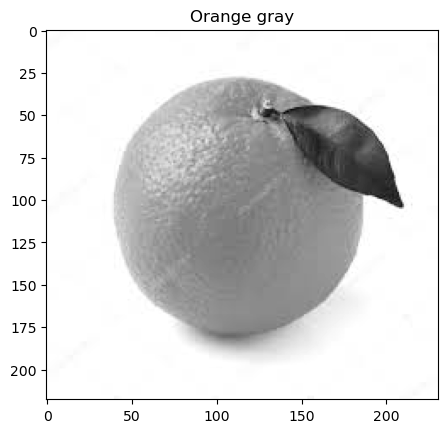

Orange shape: (218, 231)


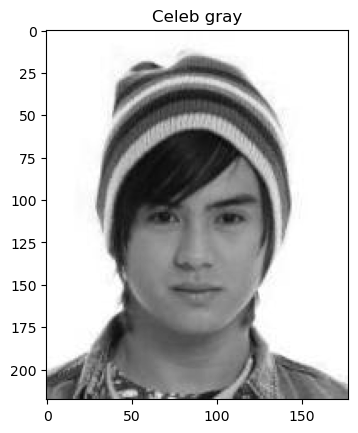

Celeb shape: (218, 178)


In [77]:
# set images pathes
orange_path = '../data/orange.jpeg'
celeb_path = '../data/celeb.jpeg'
# read imgs
img_orange = cv.imread(orange_path, cv.IMREAD_GRAYSCALE)
img_celeb = cv.imread(celeb_path, cv.IMREAD_GRAYSCALE)

display_image('Orange gray', img_orange)
print(f"Orange shape: {img_orange.shape}")
display_image('Celeb gray', img_celeb)
print(f"Celeb shape: {img_celeb.shape}")

* Create a 7 × 7 Gaussian kernel with sigma=1.

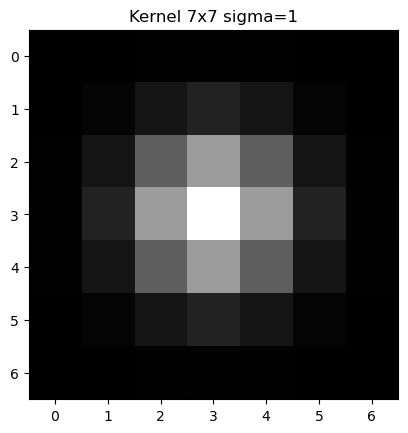

In [78]:

kernel_size = 7
kernel = kernel = cv.getGaussianKernel(kernel_size, 1)
kernel_2d = kernel * kernel.T

display_image('Kernel 7x7 sigma=1', kernel_2d)

In [79]:
def blur_im_spatial(image, kernel):
    """
    Blurs the image using spatial filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    return cv.filter2D(image,  -1, kernel=kernel_2d).astype(np.uint8)


* Blur the images by convolving the image with the Gaussian kernel directly in
the spatial domain. You may use the library function (cv2.filter2D).

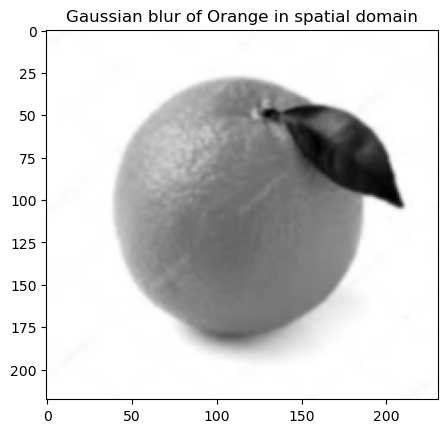

In [80]:
start = time.perf_counter()
blur_img_orange_spatial = blur_im_spatial(img_orange, kernel=kernel_2d)
end = time.perf_counter()
orange_spatial_time = end - start
display_image('Gaussian blur of Orange in spatial domain', blur_img_orange_spatial)

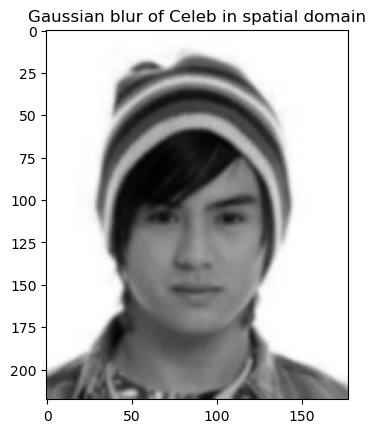

In [81]:
start = time.perf_counter()
blur_img_celeb_spatial = blur_im_spatial(img_celeb, kernel=kernel_2d)
end = time.perf_counter()
celeb_spatial_time = end - start
display_image('Gaussian blur of Celeb in spatial domain', blur_img_celeb_spatial)

* Now we are going to blur the images in the frequency domain using Fourier
Transform. We multiply the kernel function and the frequency image instead
of applying convolution. To get the final result, we transform back to the image
space. You may use functions included in the package numpy.fft to apply the
transform and its inverse.

In [82]:
# blur the image in the frequency domain
def blur_im_freq(image, kernel):
   
    # compute fft of image
    fft_image = np.fft.fft2(image)
    # compute fft of kernel with the same shape as image
    fft_kernel = np.fft.fft2(kernel, s=image.shape)
    fft_kernel_shift = np.fft.fftshift(fft_kernel)
    display_image('FFT of kernel', np.log(np.abs(fft_kernel_shift)))
    # compute convolution in frequency domain
    fft_result = fft_image * fft_kernel
    # compute inverse fft
    result = np.fft.ifft2(fft_result)
    # return real part of the result
    return np.abs(result).astype(np.uint8)

In [83]:
def blur_im_freq(image, kernel):
    """
    Blurs the image using frequency filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    image_height, image_width = image.shape
    kern_height, kern_width = kernel.shape
    # compute padding to make kernel shape equal to image shape
    padding_top = image_height // 2 - kern_height // 2
    padding_botton = image_height // 2 - kern_height // 2 - 1
    padding_left = image_width // 2 - kern_width // 2
    padding_right = image_width // 2 - kern_width // 2 - 1


    if(image_width % 2 == 1):
        padding_right += 1 
    # add padding to kernel
    padded_kernel = np.pad(
        kernel, pad_width=((padding_top, padding_botton), (padding_left, padding_right)),
        mode="constant", constant_values=0
    )

    # compute fft of image
    image_freq = np.fft.fft2(image)
    # compute fft of padded kernel 
    kernel_freq = np.fft.fft2(padded_kernel)
    # display_image('FFT of kernel', np.log(np.abs(kernel_freq)))
    # compute convolution in frequency domain
    fft_result_freq = image_freq * kernel_freq
    # compute inverse fft
    fft_result = np.fft.ifft2(fft_result_freq)

    # fixing the shift
    fft_result = np.fft.fftshift(fft_result)
    # return real part of the result
    fft_result = np.abs(fft_result).clip(min=0, max=255)  # clipping to [0, 255] because of numerical errors the max values are slightly above 255

    # ??? casting to uint8 is not needed because of clipping, but if I cast to uint8, it makes the difference between spatial and frequency domain higher ???
    # I dont understand Why

    return fft_result

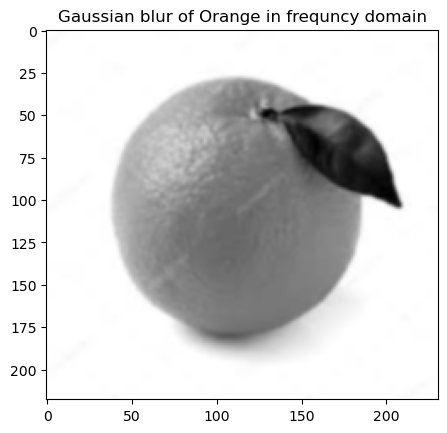

In [84]:
start = time.perf_counter()
blur_img_orange_frequency = blur_im_freq(img_orange, kernel=kernel_2d)
end = time.perf_counter()
orange_freq_time = end - start
display_image('Gaussian blur of Orange in frequncy domain', blur_img_orange_frequency)

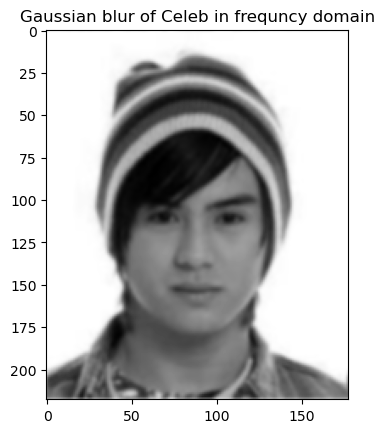

In [85]:
start = time.perf_counter()
blur_img_celeb_frequency = blur_im_freq(img_celeb, kernel=kernel_2d)
end = time.perf_counter()
celeb_freq_time = end - start
display_image('Gaussian blur of Celeb in frequncy domain', blur_img_celeb_frequency)

* Visualise the results for both images and report the mean absolute difference
between the two blurring methods and the time taken by each of them.

In [86]:
def difference_between(im_1,im_2):
    """
    Computes the absolute difference and
    mean absolute difference between two images.
    """
    diff = np.abs(np.subtract(im_1.astype(np.float32), im_2.astype(np.float32)))
    mean_diff = np.mean(diff)
    return diff, mean_diff

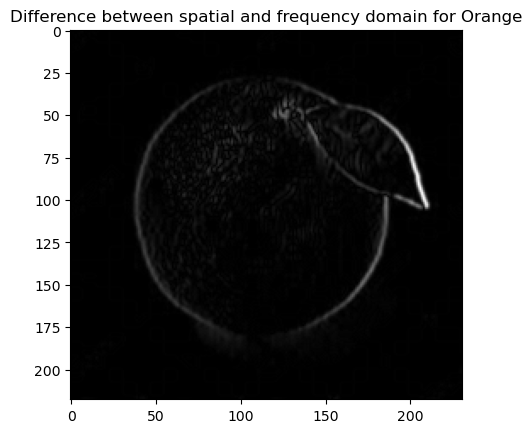

Orange mean difference: 1.357424259185791


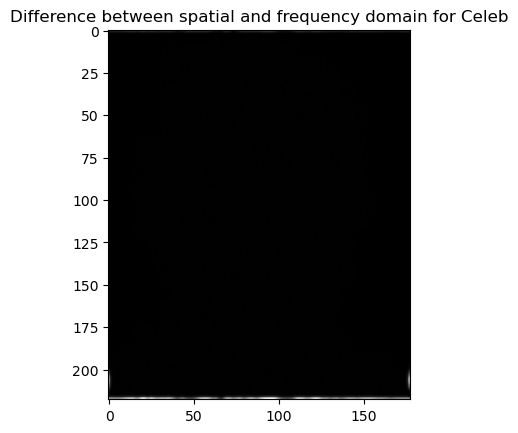

Celeb mean difference: 1.357424259185791

Orange spatial time: 0.0006940999999187625
Orange frequency time: 0.01381020000007993
Celeb spatial time: 0.0005037999999331078
Celeb frequency time: 0.01555499999994936


In [87]:
orange_diff, orange_mean_diff = difference_between(blur_img_orange_spatial, blur_img_orange_frequency)
celeb_diff, celeb_mean_diff = difference_between(blur_img_celeb_spatial, blur_img_celeb_frequency)

display_image('Difference between spatial and frequency domain for Orange', orange_diff)
print(f"Orange mean difference: {orange_mean_diff}")
display_image('Difference between spatial and frequency domain for Celeb', celeb_diff)
print(f"Celeb mean difference: {orange_mean_diff}")
print()

print(f"Orange spatial time: {orange_spatial_time}")
print(f"Orange frequency time: {orange_freq_time}")

print(f"Celeb spatial time: {celeb_spatial_time}")
print(f"Celeb frequency time: {celeb_freq_time}")


## Task 2. Template Matching    
In this task, we will implement template matching using Sum
Square Difference and normalized cross-correlation similarity measures. The input
image is RidingBike.jpeg and the template image (what we want to find in the
larger input image) is RidingBikeTemplate.jpeg

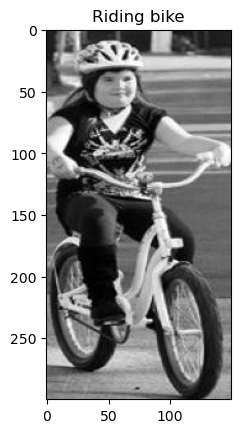

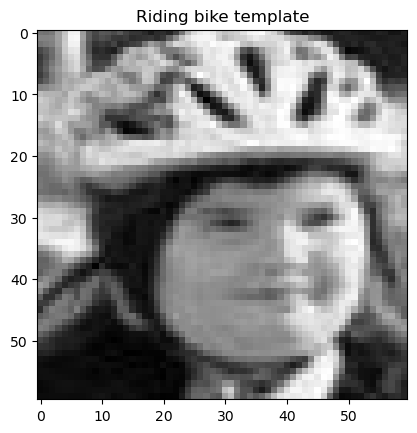

In [88]:
# set images pathes
riding_bike_path = '../data/ridingBike.jpeg'
riding_bike_template_path = '../data/ridingBikeTemplate.jpeg'
# read imgs
riding_bike = cv.imread(riding_bike_path, cv.IMREAD_GRAYSCALE)
riding_bike_template = cv.imread(riding_bike_template_path, cv.IMREAD_GRAYSCALE)

display_image('Riding bike', riding_bike)
display_image('Riding bike template', riding_bike_template)

* Implement Sum Square Difference.

$$
h[n, m] = \sum_{k,l}^{}(g[k,l] - f[m+k, n+l])^2
$$

In [89]:
def sum_squared_diff(im_1, im_2):
    """
    Computes the sum of squared differences between two images.
    """
    return np.sum(np.square(np.subtract(im_2, im_1)))

* Implement template matching using your implementation of Sum Square Difference.

In [90]:
def templ_matching_ssd(image, template):
    """
    Computes the sum of squared differences between the template and every possible location in the image.
    :param im: image to search in
    :param template: template to search for
    :return: image with the sum of squared differences
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = sum_squared_diff(
                image[i : i + template_h, j : j + template_w], template
            )

    return result

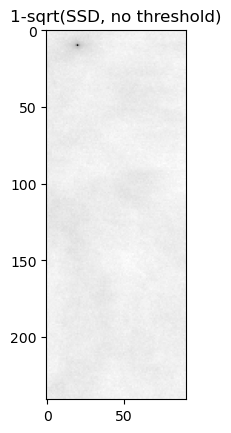

In [91]:
similarity_ssd_img = templ_matching_ssd(riding_bike, riding_bike_template)
similarity_ssd_img = similarity_ssd_img / similarity_ssd_img.max()
display_image('1-sqrt(SSD, no threshold)', similarity_ssd_img)

## for some reason detection is shown with lower values

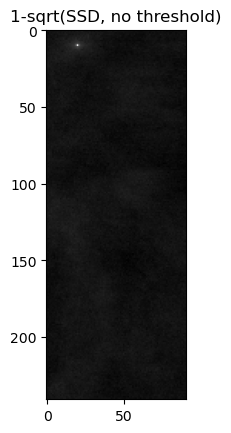

In [92]:
## I will use 1 - similarity_ssd_img to get the same result as in the lecture

similarity_ssd_img = 1 - similarity_ssd_img
display_image('1-sqrt(SSD, no threshold)', similarity_ssd_img)

* Implement Normalized Cross-correlation.

$$
h[n, m] = \frac{\sum_{k,l}^{}(g[k,l] - \bar{g})- (f[m+k, n+l] - \bar{f_{m,n}})}{\left(\sum_{k,l}^{}(g[k,l] - \bar{g})^2 \sum_{k,l}^{}(f[m+k, n+l] - \bar{f_{m,n}})^2\right)^{0.5}}
$$

In [93]:
def normalized_cross_correlation(im_1, im_2):
    """
    Computes the normalized cross correlation between two images.
    """
    im_1_mean = np.mean(im_1)
    im_2_mean = np.mean(im_2)

    norm = np.sqrt(
                np.sum(np.power(im_2 - im_2_mean, 2))
                * np.sum(np.power(im_1 - im_2_mean, 2))
            )

    return np.sum(np.multiply(im_2 - im_2_mean, im_1 - im_1_mean)) / norm
    

* Implement template matching using Normalized Cross-correlation.

In [94]:
def templ_matching_nxc(image, template):
    """
    Computes the normalized cross correlation between the template and every possible location in the image.
    :param image: image to search in
    :param template: template to search for
    :return: image with the normalized cross correlation
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = normalized_cross_correlation(
                image[i : i + template_h, j : j + template_w], template
            )
    if result.min() < 0:
        result = result - result.min()
    result /= result.max()
    return result

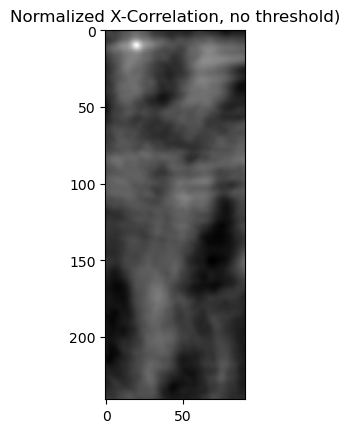

In [95]:
similarity_nxc_img = templ_matching_nxc(riding_bike, riding_bike_template)
similarity_nxc_img = similarity_nxc_img - similarity_nxc_img.min()
similarity_nxc_img = similarity_nxc_img / similarity_nxc_img.max()
display_image('Normalized X-Correlation, no threshold)', similarity_nxc_img)

* Draw rectangles on the image where similarity ≥ 0.5 for both methods. You
may experiment with other threshold values to determine the matching.

In [96]:
def draw_rectangle_at_detection(image, template_shape, detection_positions):
    detection_positions = zip(detection_positions[0], detection_positions[1])
    for detection_position in detection_positions:
        cv.rectangle(
            image,
            (detection_position[1], detection_position[0]),
            (detection_position[1] + template_shape[1], detection_position[0] + template_shape[0]),
            0
        )
    return image

(array([10], dtype=int64), array([20], dtype=int64))


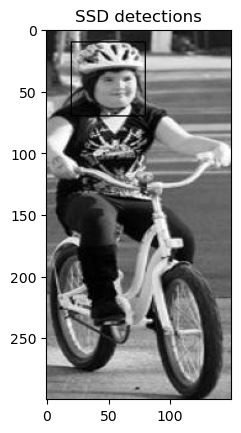

In [97]:
threshold = 0.5
detections = np.where(similarity_ssd_img >= threshold)
print(detections)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image('SSD detections', result)

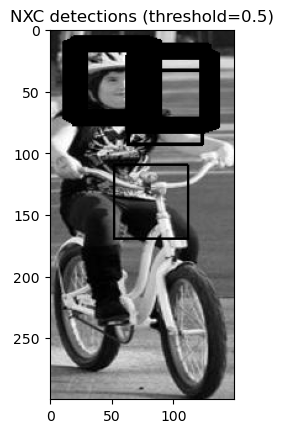

In [98]:
threshold = 0.5
detections = np.where(similarity_nxc_img >= threshold)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image('NXC detections (threshold=0.5)', result)

ok, too many false positive detections
lets make threshold higher

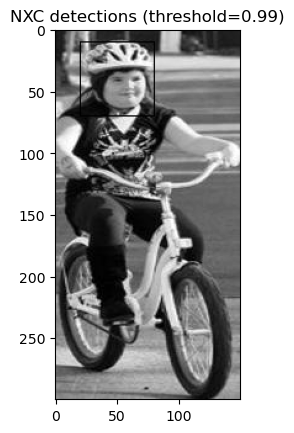

In [99]:
threshold = 0.99
detections = np.where(similarity_nxc_img >= threshold)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image(f'NXC detections (threshold={threshold})', result)

## Task 3. Template matching multi-scale

In this task, we will build the Gaussian pyramid to make template matching work at different resolutions. 
Read the image DogGray.jpeg and the template DogTemplate.jpeg

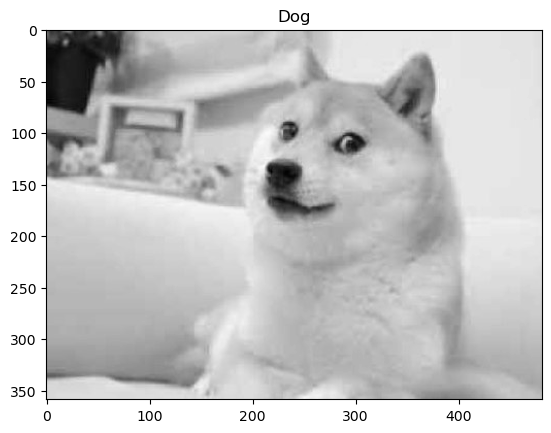

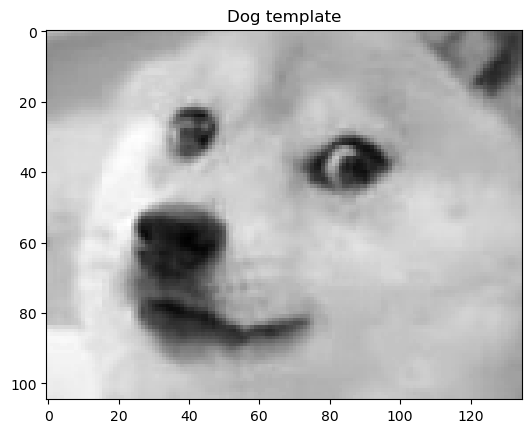

In [100]:
# set images pathes
dog_path = '../data/DogGray.jpeg'
dog_template_path = '../data/DogTemplate.jpeg'
# read imgs
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
dog_template = cv.imread(dog_template_path, cv.IMREAD_GRAYSCALE)

display_image('Dog', dog)
display_image('Dog template', dog_template)

* Build a 5 level Gaussian pyramid by downsampling input image yourself.

In [101]:
def build_gaussian_pyramid(image, num_levels):
    """
    Builds a Gaussian pyramid of an image.
    :param image: image to build the pyramid from
    :param num_levels: number of levels in the pyramid
    :return: Gaussian pyramid
    """
    pyramid = [image]
    for i in range(num_levels - 1):
        # pyramid.append(cv.pyrDown(pyramid[i]))
        blurred_image = cv.GaussianBlur(src=image, ksize=(0, 0), sigmaX=1)
        image = blurred_image[0::2, 0::2] # downsampling by 2 (even rows and columns)
        pyramid.append(image)
    return pyramid

    

* Now create a 5 level Gaussian pyramid using cv2.pyrDown. Compare it with
your implementation by printing the mean absolute difference at each level.

In [102]:
def build_gaussian_pyramid_opencv(image, num_levels):
    pyramid = [image]
    for i in range(num_levels - 1):
        pyramid.append(cv.pyrDown(pyramid[i])) 
    return pyramid

Mean absolute difference between the two images (lavel 0): 0.0
Mean absolute difference between the two images (lavel 1): 3.4180267404333793
Mean absolute difference between the two images (lavel 2): 7.099173553719008
Mean absolute difference between the two images (lavel 3): 11.850273224043717
Mean absolute difference between the two images (lavel 4): 26.189340813464234


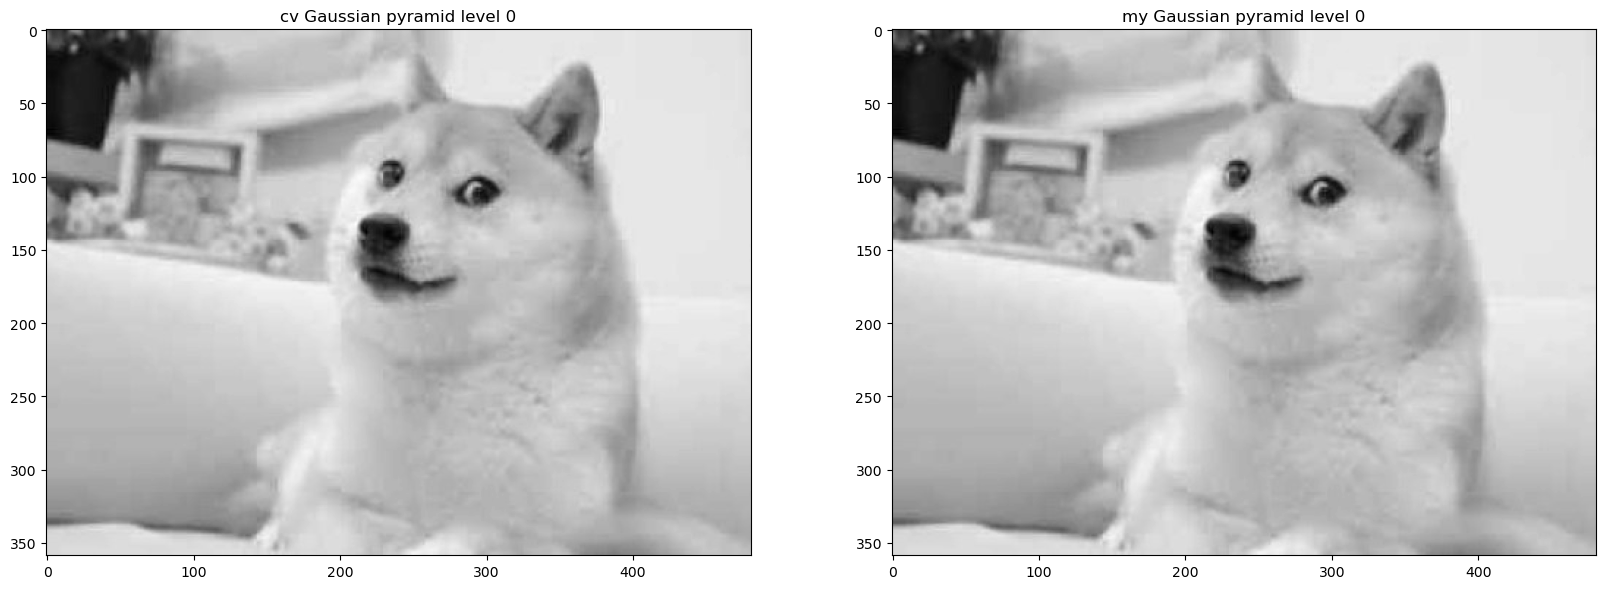

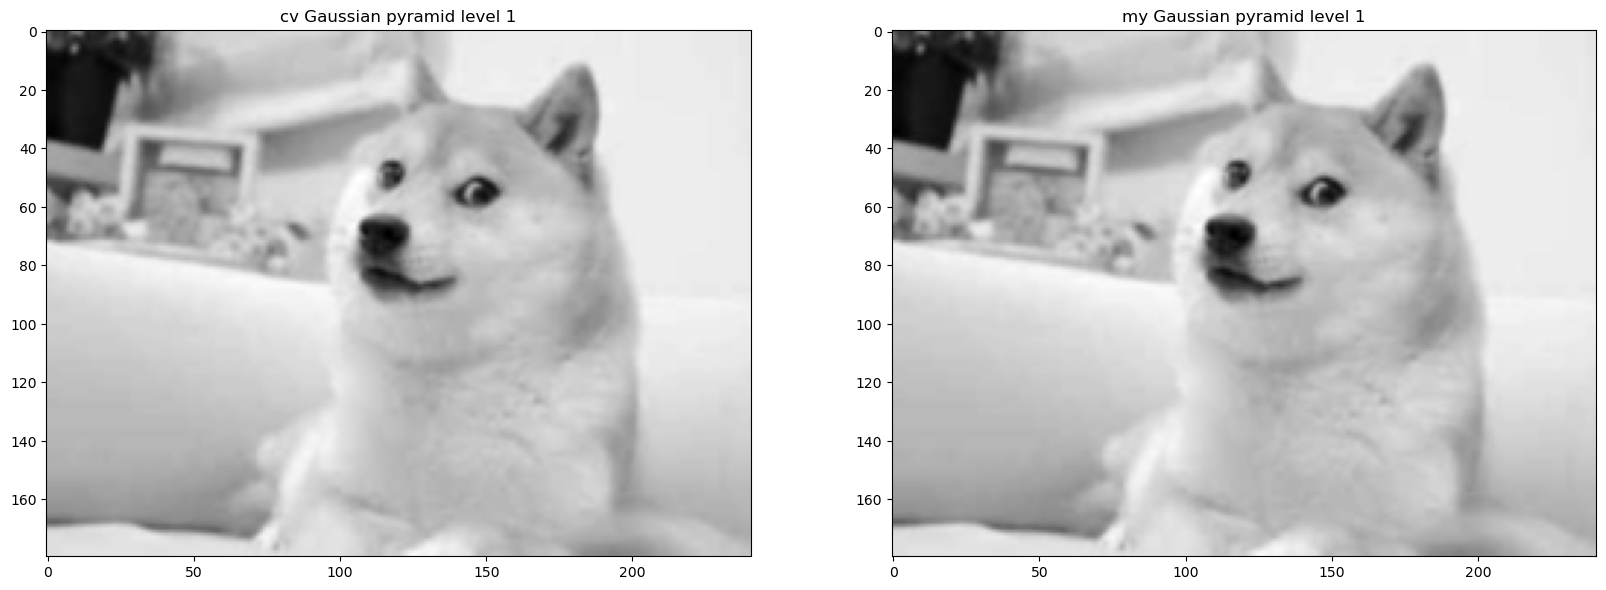

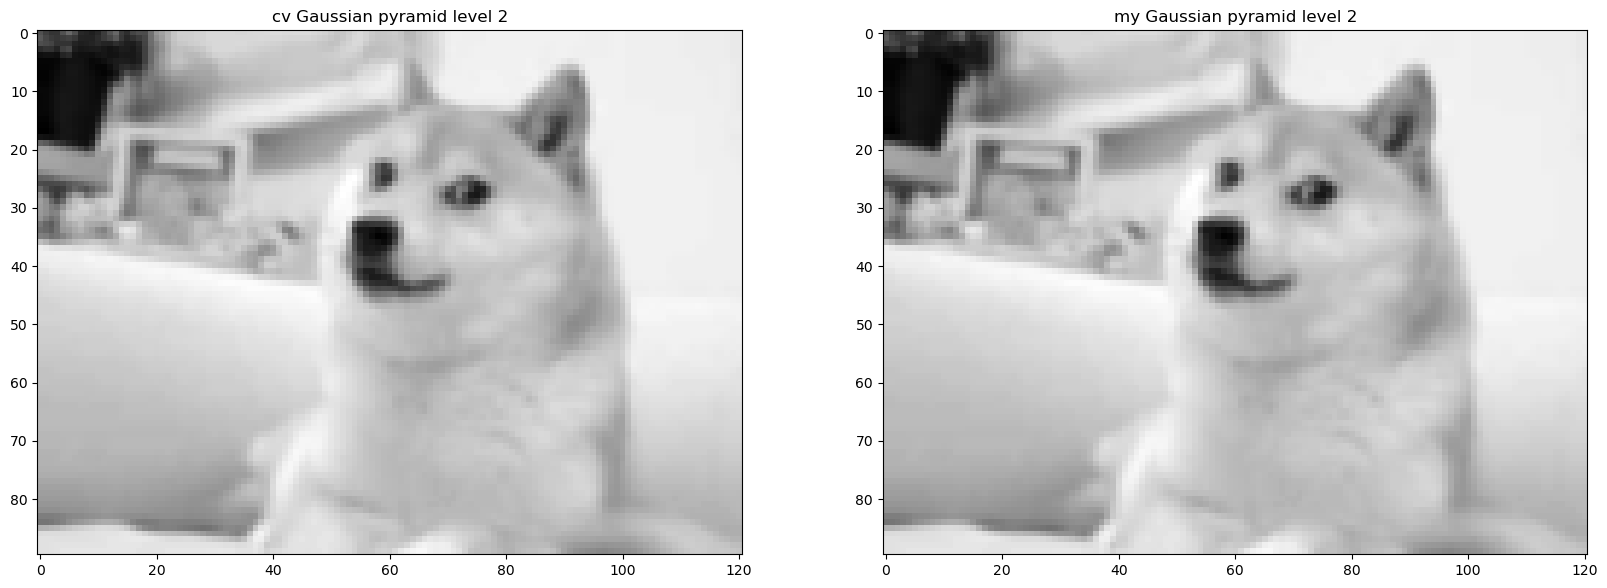

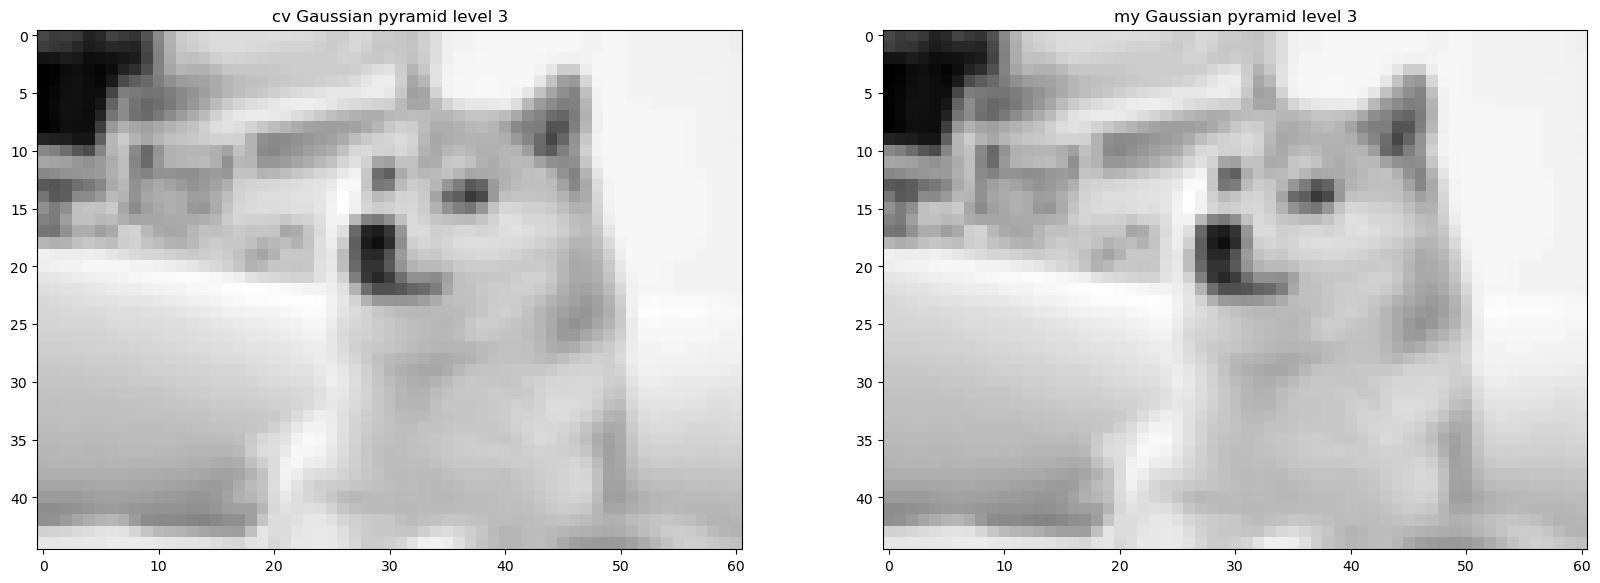

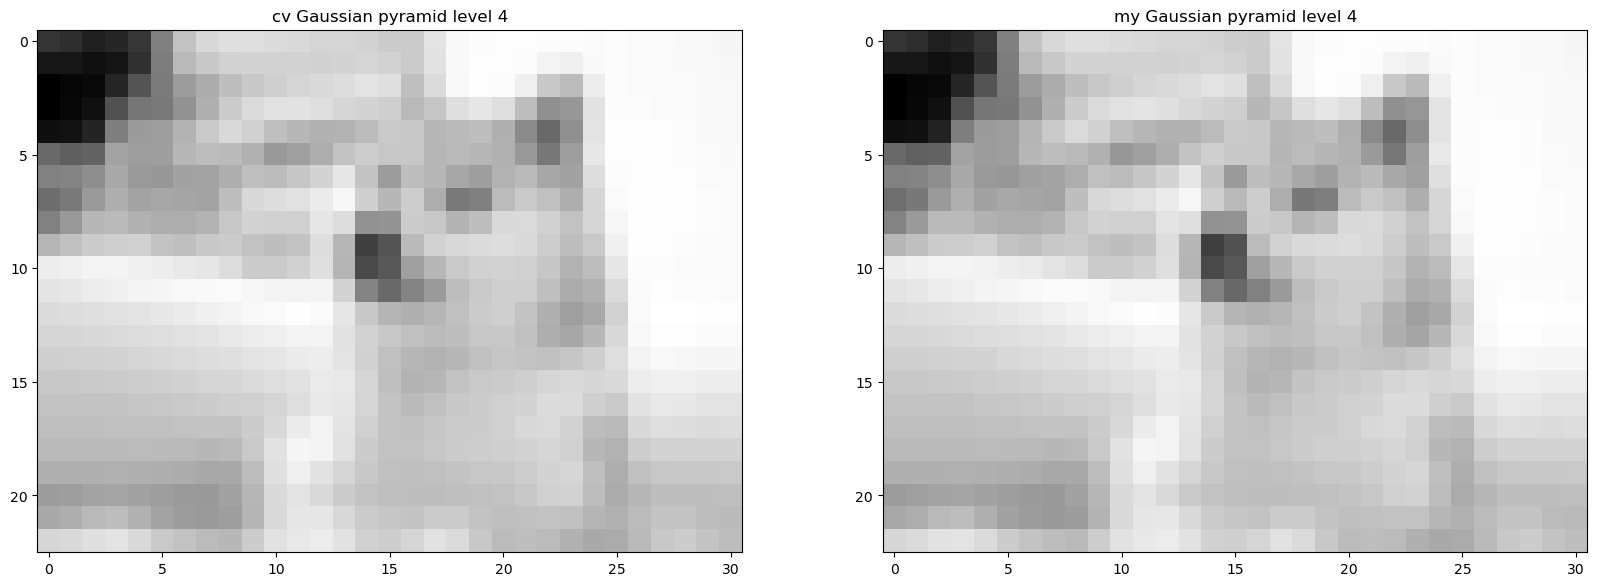

In [103]:
pyramid_my = build_gaussian_pyramid(dog, 5)
pyramid_cv = build_gaussian_pyramid_opencv(dog, 5)
for i, images in enumerate(zip(pyramid_cv, pyramid_my)):
    display_image(f'cv Gaussian pyramid level {i}', images[0], f'my Gaussian pyramid level {i}', images[1]) 
    print(f"Mean absolute difference between the two images (lavel {i}): {np.mean(np.abs(images[0] - images[1]))}")

* Perform template matching by using your implementation of normalized cross
correlation . Report the time taken by this method.

Time for NXC: 84.52932839999994 seconds


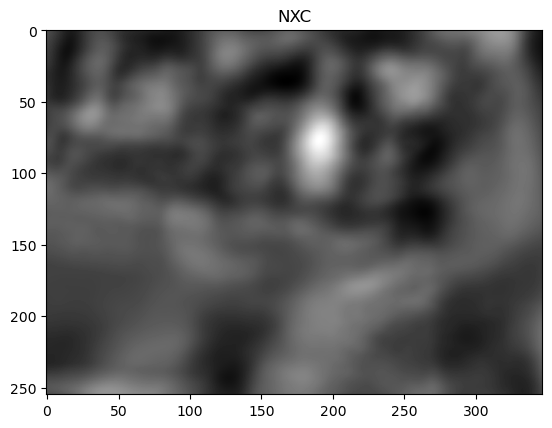

In [104]:
start = time.perf_counter()
similarity_nxc_img_ = templ_matching_nxc(dog, dog_template)
end = time.perf_counter()
print(f"Time for NXC: {end - start} seconds")
display_image('NXC', similarity_nxc_img_)

1.0


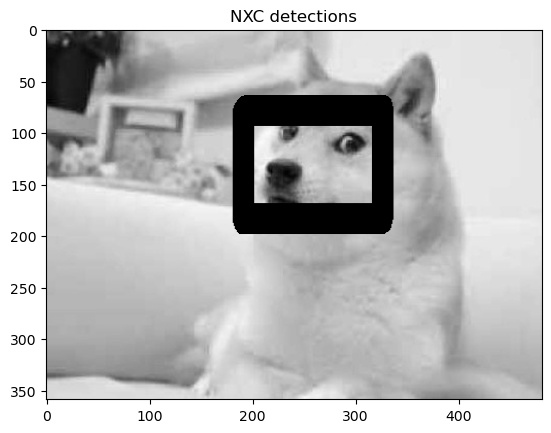

In [105]:
detections = np.where(similarity_nxc_img_ >= 0.7613)
print(similarity_nxc_img_.max(  ))
result = draw_rectangle_at_detection(dog, dog_template.shape, detections)
display_image('NXC detections', result)

* Show the template matching using normalized cross correlation at the different
Pyramid levels of both the template and input images (you can use the pyramid
obtained by pyrDown).

1.0
Time for NXC image in level 0: 84.52932839999994 seconds
1.0
Time for NXC image in level 1: 6.749885199999881 seconds
1.0
Time for NXC image in level 2: 0.7120279000000664 seconds
1.0
Time for NXC image in level 3: 0.11684119999995346 seconds
1.0
Time for NXC image in level 4: 0.026984399999946618 seconds


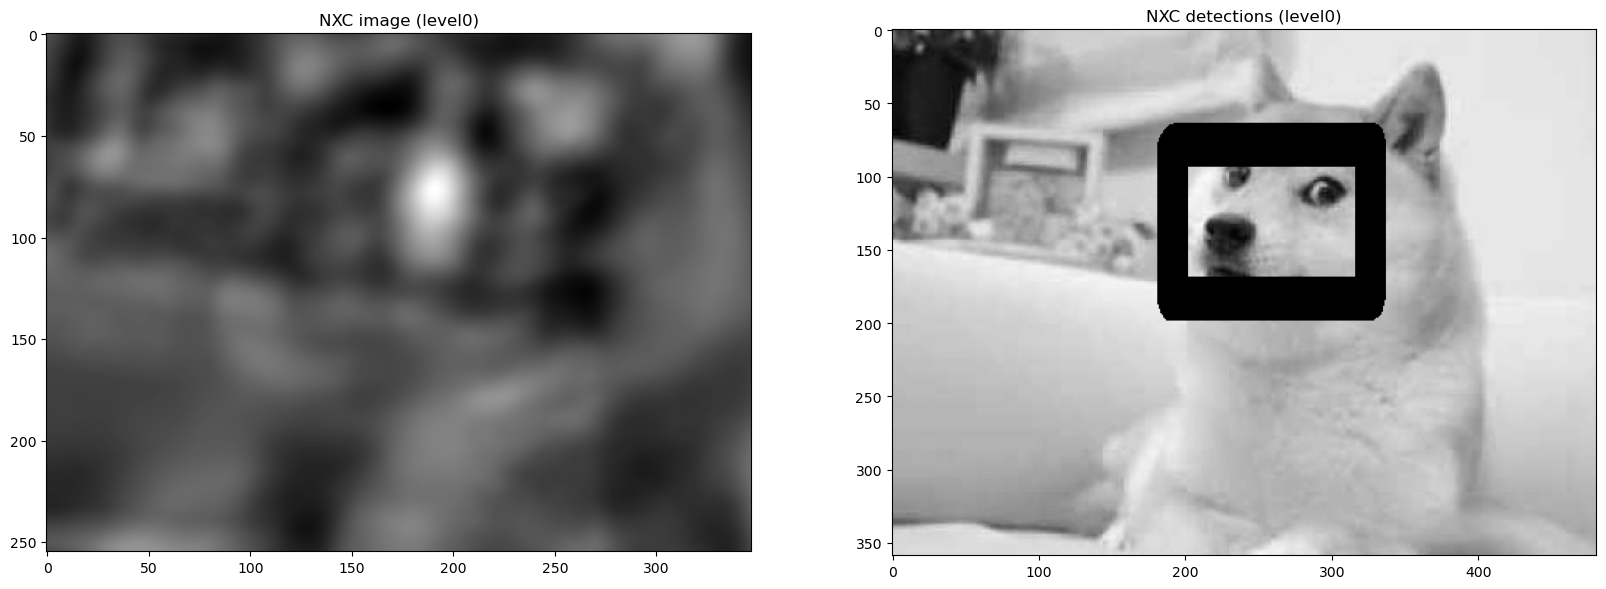

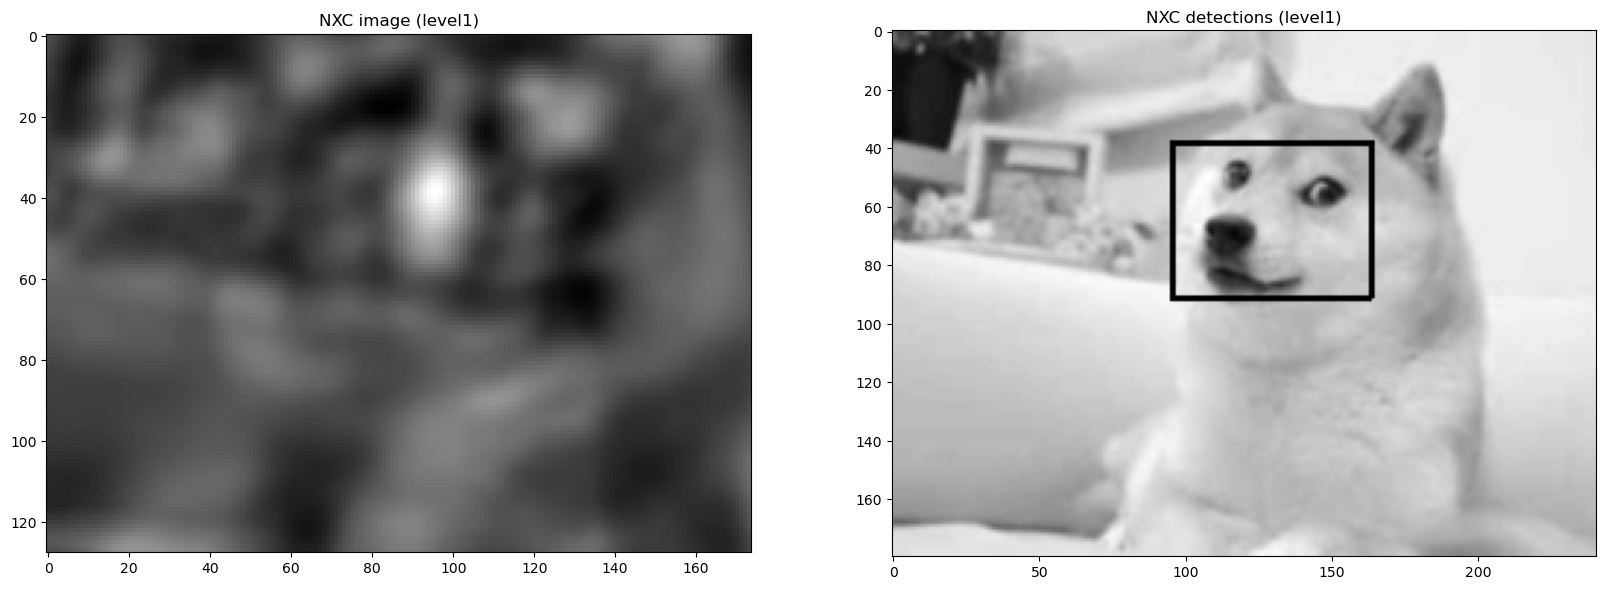

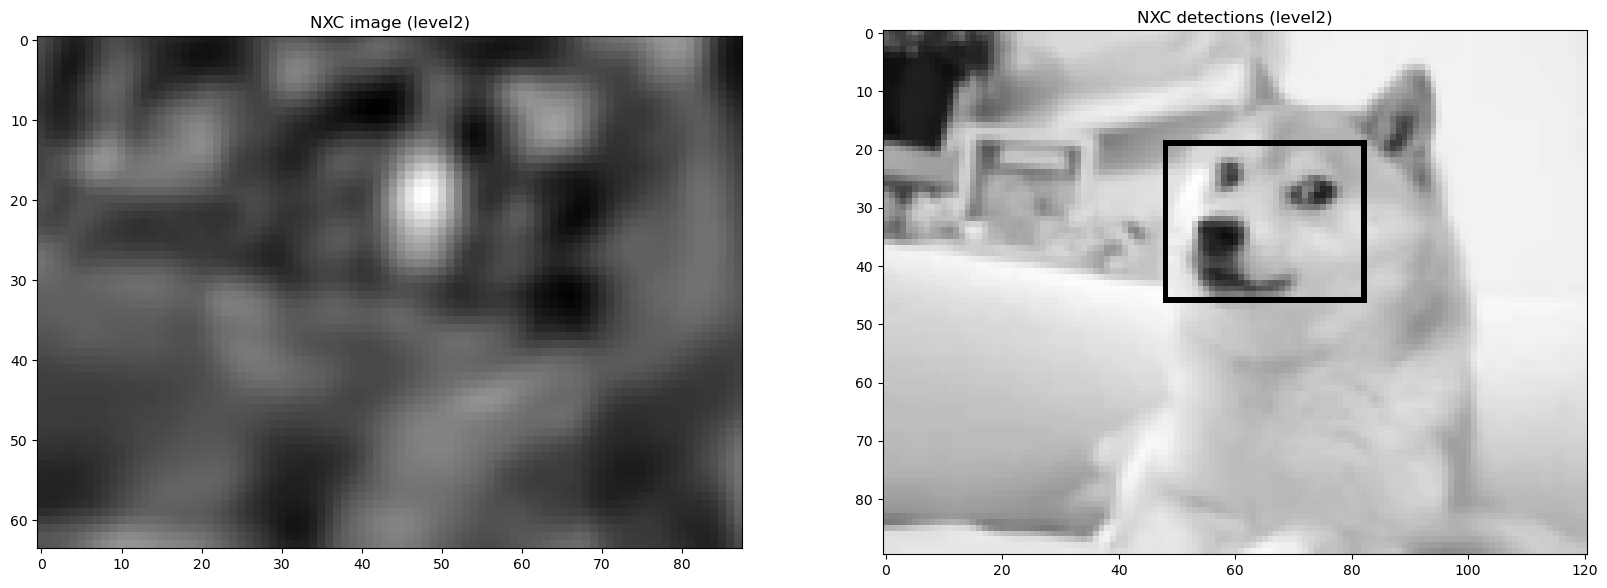

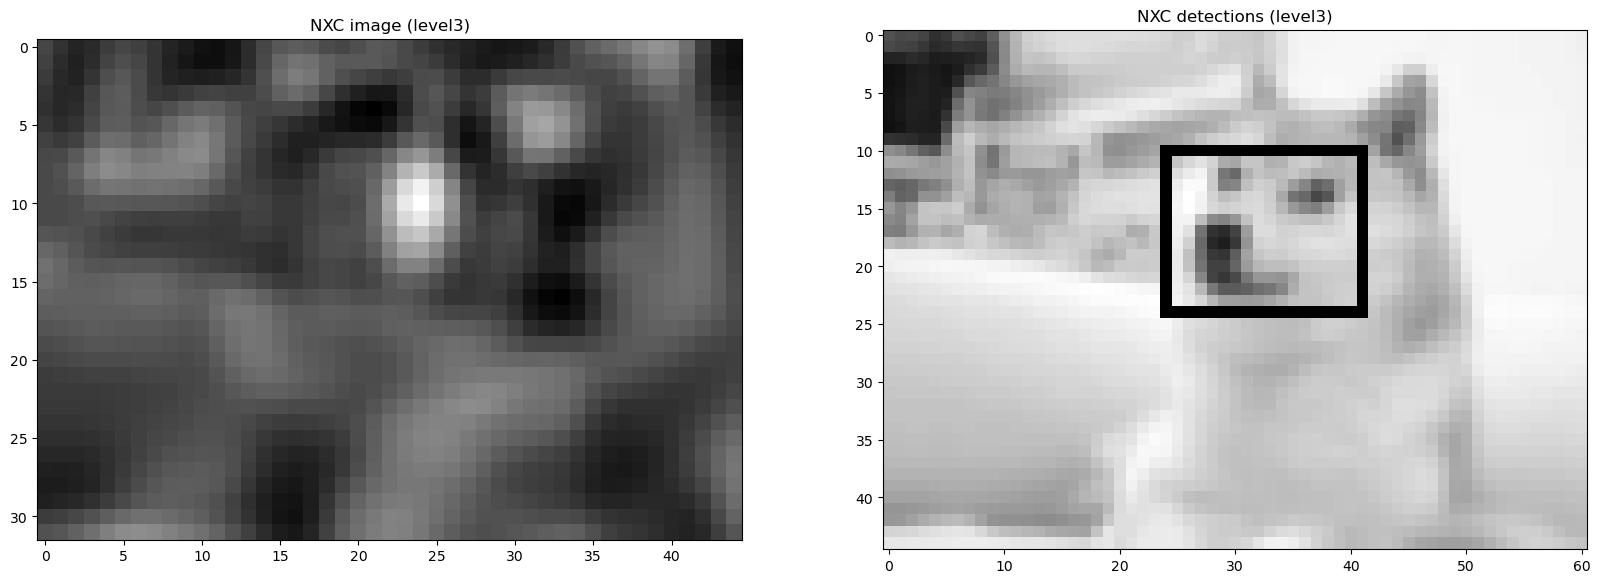

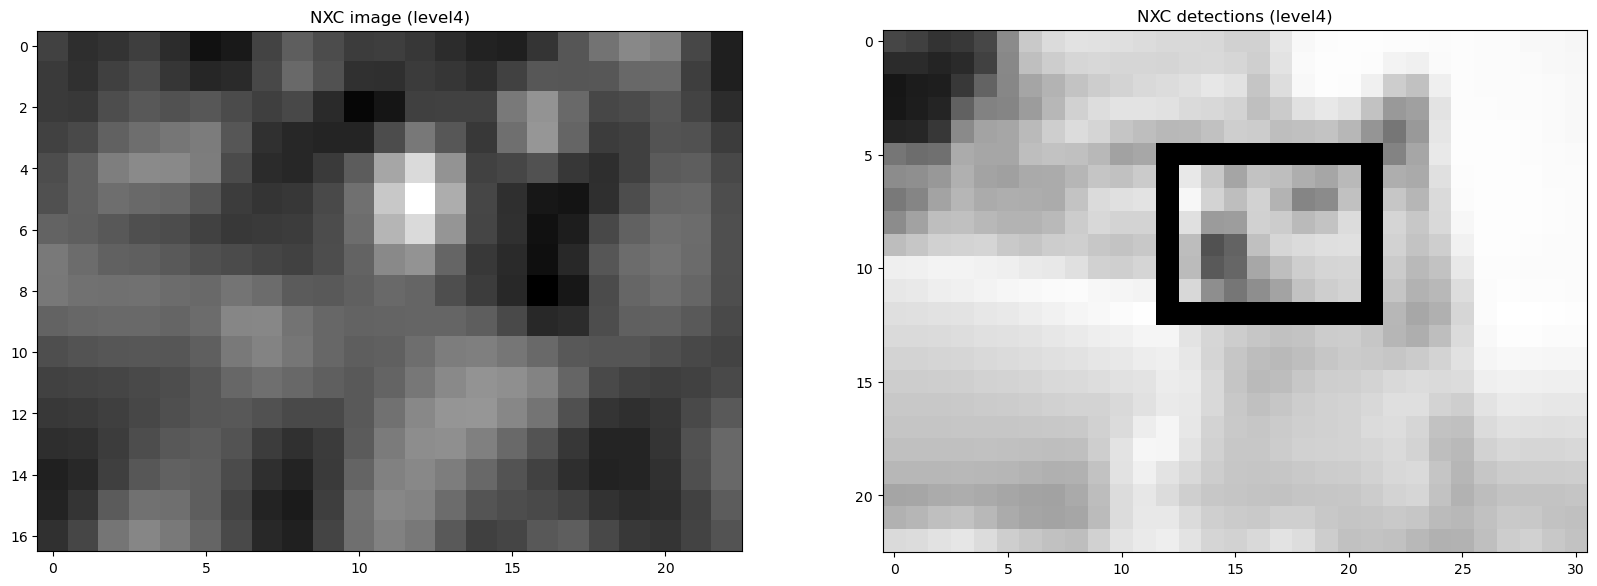

In [106]:
# pyramid_cv
pyramid_tmpl_cv = build_gaussian_pyramid_opencv(dog_template, 5)

similarity_nxc_img_arr = [similarity_nxc_img_]
time_arr = [end - start]
for i in range(1, len(pyramid_cv)):
    start = time.perf_counter()
    similarity_nxc_img_arr.append(templ_matching_nxc(pyramid_cv[i], pyramid_tmpl_cv[i]))
    end = time.perf_counter()
    time_arr.append(end - start)

for i, simil_image in enumerate(similarity_nxc_img_arr):
    detections = np.where(simil_image >= simil_image.max( ) - 0.003)
    print(simil_image.max( ))
    result_ = draw_rectangle_at_detection(pyramid_cv[i], pyramid_tmpl_cv[i].shape, detections)
    display_image(f'NXC image (level{i})', simil_image, f'NXC detections (level{i})', result_)
    print(f"Time for NXC image in level {i}: {time_arr[i]} seconds")

* As you observed, implementing template matching naively is not efficient. Now
we will rely on the pyramid technique while constraining the search space in
order to make it faster. Follow the procedure described in the lecture slides:
search only in regions with high similarity in the previous pyramid level. Compare
the times taken by this method and the naive implementation.

In [137]:

def template_matching_multiple_scales(pyramid_image, pyramid_template, visualize=False):
    """
    Performs template matching on multiple scales.
    :param pyramid_image: image pyramid
    :param pyramid_template: template pyramid
    :return: similarity map
    """

    # reverse pyramid_image and pyramid_template
    pyramid_image = pyramid_image[::-1]
    pyramid_template = pyramid_template[::-1]


    similarity_img = templ_matching_nxc(pyramid_image[0], pyramid_template[0])
    if similarity_img.min() < 0:
        similarity_img = similarity_img - similarity_img.min()
    similarity_img = similarity_img / similarity_img.max()

    if visualize:
        display_image(f'NXC-multiscale similarity image (level)', similarity_img)

    threshold = 0.75
    search_window_size = 7

    for i in range(1, len(pyramid_image)):
        detection_positions = np.where(similarity_img >= threshold)
        print(f"Number of detections in level {len(pyramid_image)-i}: {len(detection_positions[0])}")
        detection_positions = zip(detection_positions[0], detection_positions[1])

        similarity_img = np.zeros_like(pyramid_image[i])

        image_height, image_width = pyramid_image[i].shape
        template_height, template_width = pyramid_template[i].shape

        
        for detection_position in detection_positions:
            
            # upscale detection position for the next level
            detection_position = [detection_position[0] * 2, detection_position[1] * 2]
            
            # check if the detection position is in the image, if not, set it to 0
            top_left_corner = max(detection_position[0] - search_window_size, 0), max(detection_position[1] - search_window_size, 0)
            detection_position[0] += template_height
            detection_position[1] += template_width

            # check if the detection position is in the image, if not, set it to heigth/width of image
            bottom_right_corner = min(detection_position[0] + search_window_size, image_height), min(detection_position[1] + search_window_size, image_width)

            patch = pyramid_image[i][
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ]

            #display_image(f'Patch', patch)

            # calculate similarity only inside of the patch
            similarity = templ_matching_nxc(patch, pyramid_template[i])
            similarity_result = np.zeros_like(patch)

            similarity_result[:similarity.shape[0], :similarity.shape[1]] = similarity 
            similarity_img_patch = similarity_img[
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ]
            # find location of increased similarity and save as mask
            mask = np.float32(similarity_result > similarity_img_patch)
            
            # increase values of similarty_img only where mask is 1 and only in the patch lacation
            similarity_img[
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ] = (mask * similarity_result + (1 - mask) * similarity_img_patch).astype(np.uint8)

        if visualize:
            display_image(f'NXC-multiscale similarity image (level{len(pyramid_image) - i-1})', similarity_img)
            
    return similarity_img


Number of detections in level 4: 4
Number of detections in level 3: 1
Number of detections in level 2: 1
Number of detections in level 1: 1
Time for NXC multiscale: 0.4220980000000054 seconds


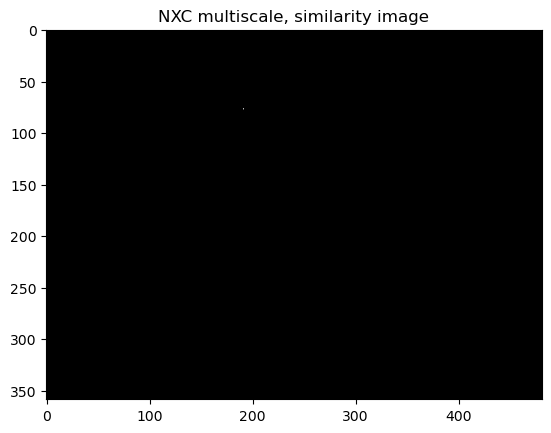

In [138]:
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
pyramid_cv = build_gaussian_pyramid_opencv(dog, 5)
pyramid_tmpl_cv = build_gaussian_pyramid_opencv(dog_template, 5)
start = time.perf_counter()
similarity_nxc_multiscale_img = template_matching_multiple_scales(pyramid_cv, pyramid_tmpl_cv)
end = time.perf_counter()
print(f"Time for NXC multiscale: {end - start} seconds")
display_image('NXC multiscale, similarity image', similarity_nxc_multiscale_img)

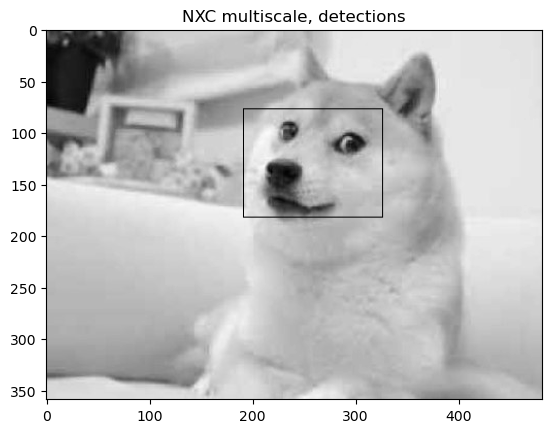

In [139]:
detections = np.where(similarity_nxc_multiscale_img >= 0.99)
result_multiscale_ = draw_rectangle_at_detection(dog, pyramid_tmpl_cv[0].shape, detections)
display_image('NXC multiscale, detections', result_multiscale_)

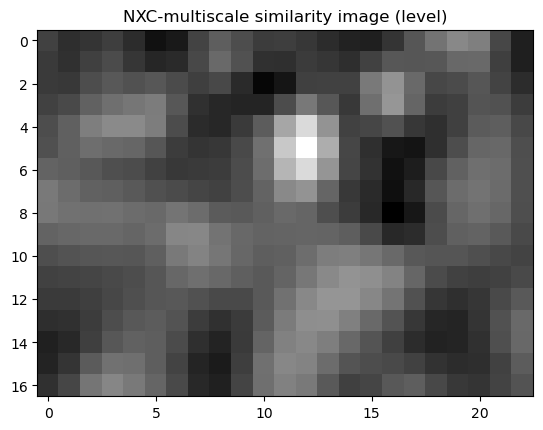

Number of detections in level 4: 4


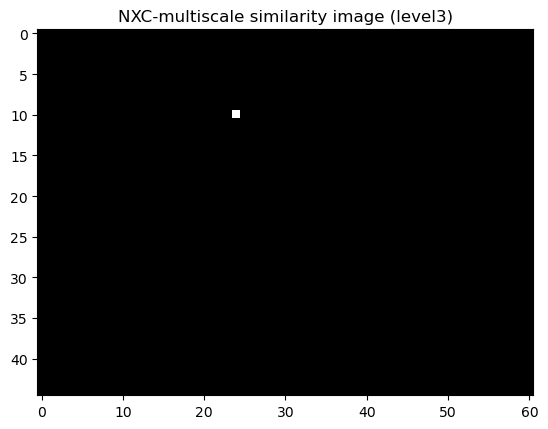

Number of detections in level 3: 1


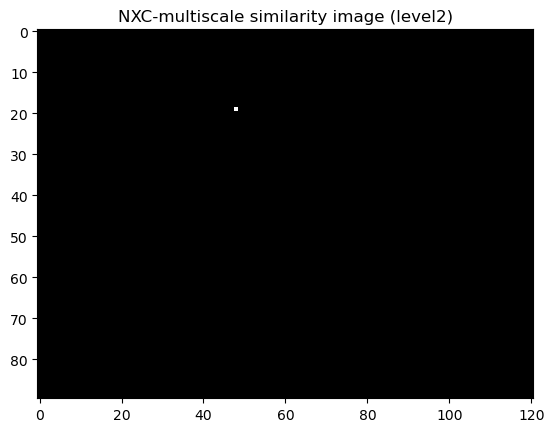

Number of detections in level 2: 1


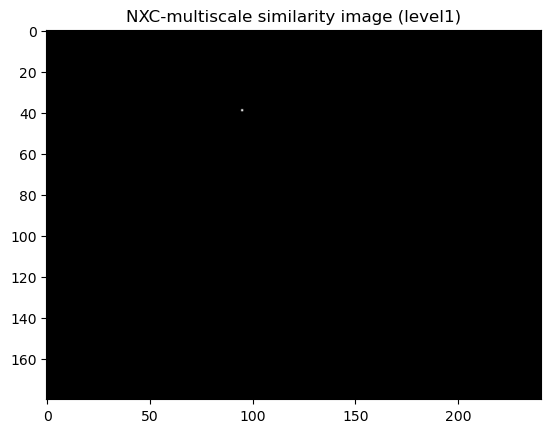

Number of detections in level 1: 1


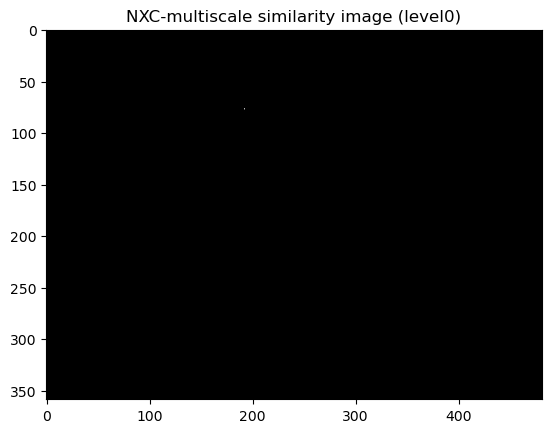

In [140]:
similarity_nxc_multiscale_img_visual = template_matching_multiple_scales(pyramid_cv, pyramid_tmpl_cv, True)


## Task 4. Pyramids for image blending In this task, we will stitch two images using pyramids.
Without pyramids, blending does not look natural because of discontinuities
between the pixel values. We will blend the images dog.jpeg and moon.jpeg.


* Load the two images dog.jpeg and moon.jpeg.

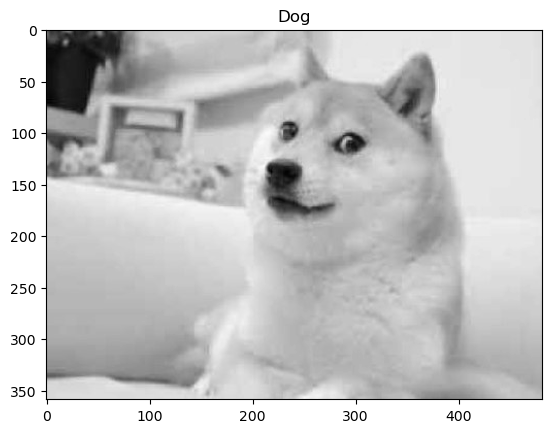

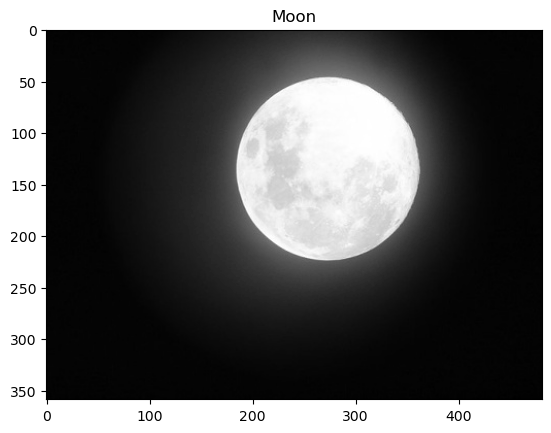

In [111]:
# set images pathes
dog_path = '../data/dog.jpeg'
moon_path = '../data/moon.jpeg'
# read imgs
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
moon = cv.imread(moon_path, cv.IMREAD_GRAYSCALE)

display_image('Dog', dog)
display_image('Moon', moon)

* Create the Gaussian Pyramids of the two images, and find their Laplacian
Pyramids LA and LB (remember that a Laplacian Pyramid is the difference
between two levels in the Gaussian Pyramid as explained in the lecture, i.e.
Li = Gi − expand(Gi+1)). Set the number of levels to 5.

In [112]:
def build_gaussian_pyramid_opencv(image, num_levels):
    pyramid = [image]
    for i in range(num_levels - 1):
        pyramid.append(cv.pyrDown(pyramid[i])) 
    return pyramid

In [113]:
def expand_opencv(image, shape):
    upscaled = cv.pyrUp(image)
    if(upscaled.shape[0] > shape[0] or upscaled.shape[1] > shape[1]):
        upscaled = upscaled[:shape[0], :shape[1]]
    return upscaled

In [114]:
def expand_my(image, shape):
    upscaled = np.repeat(image, 2, axis=0)
    upscaled = np.repeat(upscaled, 2, axis=1)
    if(upscaled.shape[0] > shape[0] or upscaled.shape[1] > shape[1]):
        upscaled = upscaled[:shape[0], :shape[1]]
    return upscaled

In [115]:
def build_laplacian_pyramid_opencv(gaussian_pyramid_image):
    pyramid = []
    for i in range(0, len(gaussian_pyramid_image) - 1):
        shape = gaussian_pyramid_image[i].shape
        expanded_img = expand_opencv(gaussian_pyramid_image[i+1], shape)
        laplacian_img = cv.subtract(gaussian_pyramid_image[i], expanded_img)
        pyramid.append(laplacian_img)
    pyramid.append(gaussian_pyramid_image[-1])
    return pyramid

In [116]:
gaussian_pyramid_dog = build_gaussian_pyramid_opencv(dog, 5)
gaussian_pyramid_moon = build_gaussian_pyramid_opencv(moon, 5)

In [117]:
laplacian_pyramid_dog = build_laplacian_pyramid_opencv(gaussian_pyramid_dog)
laplacian_pyramid_moon = build_laplacian_pyramid_opencv(gaussian_pyramid_moon)

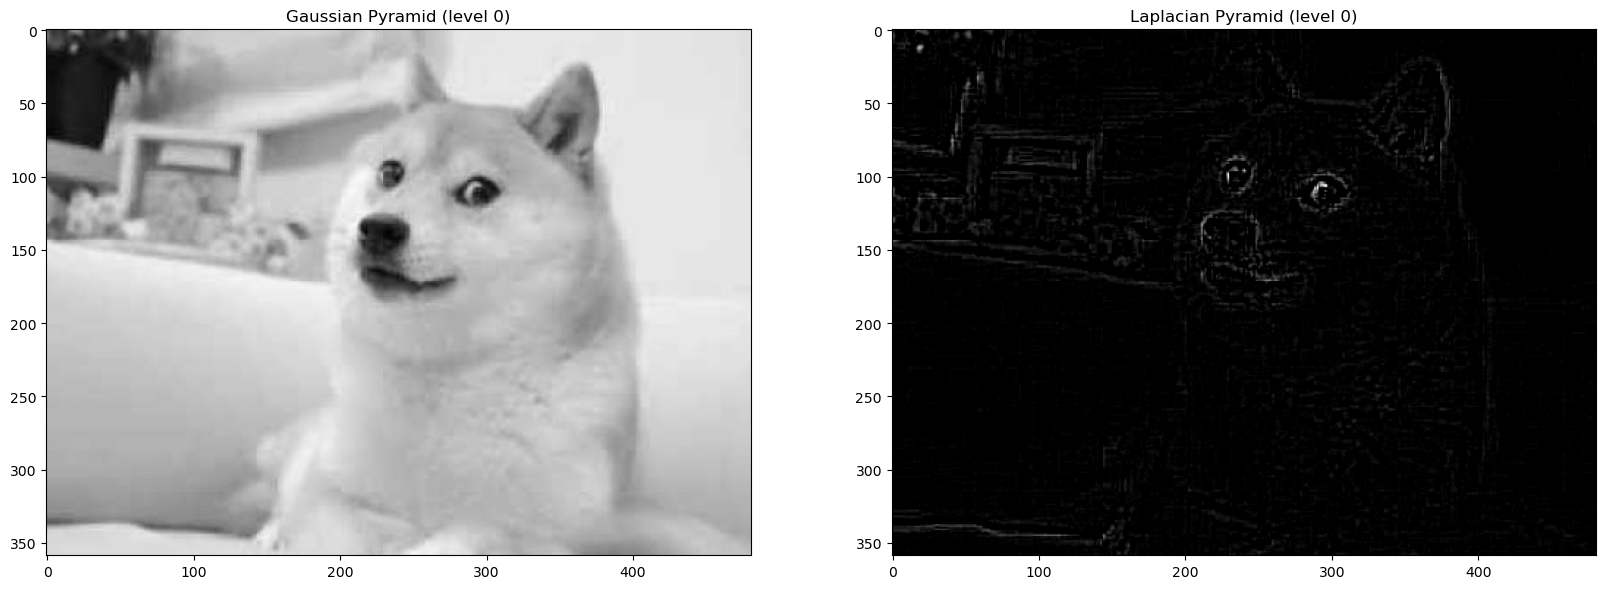

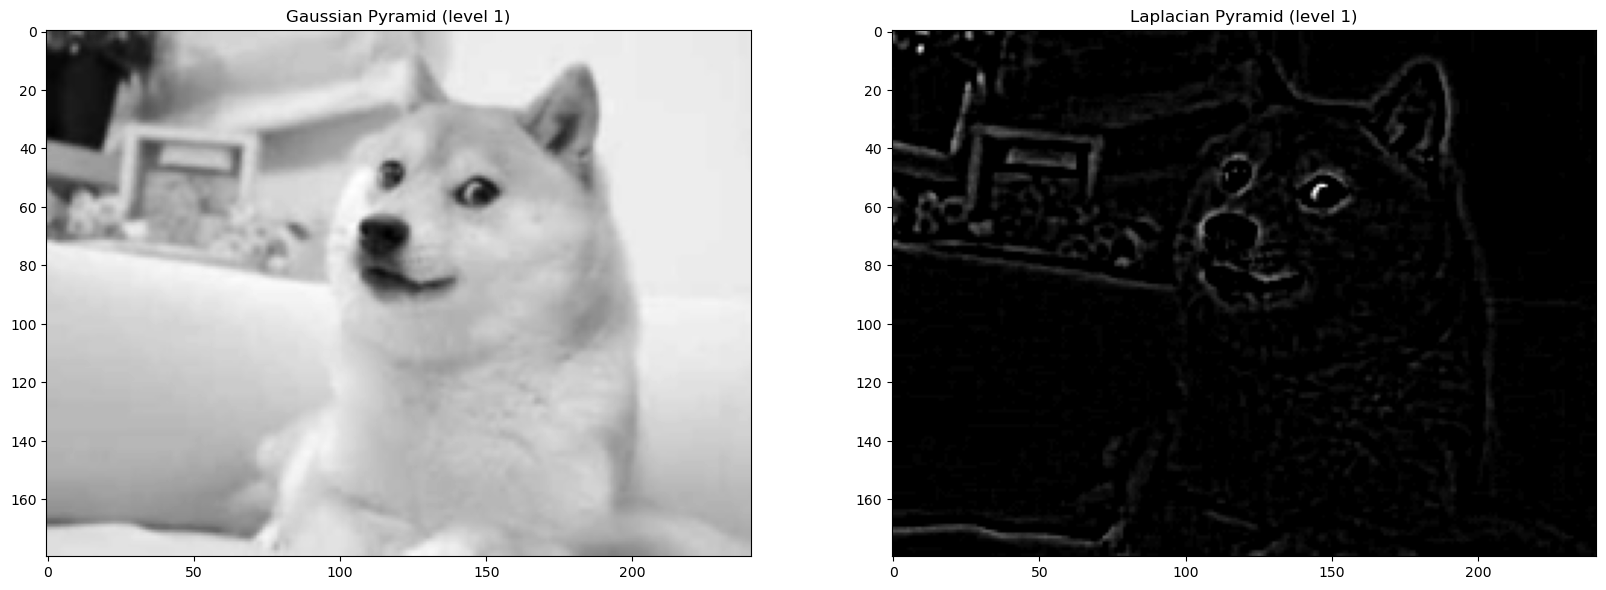

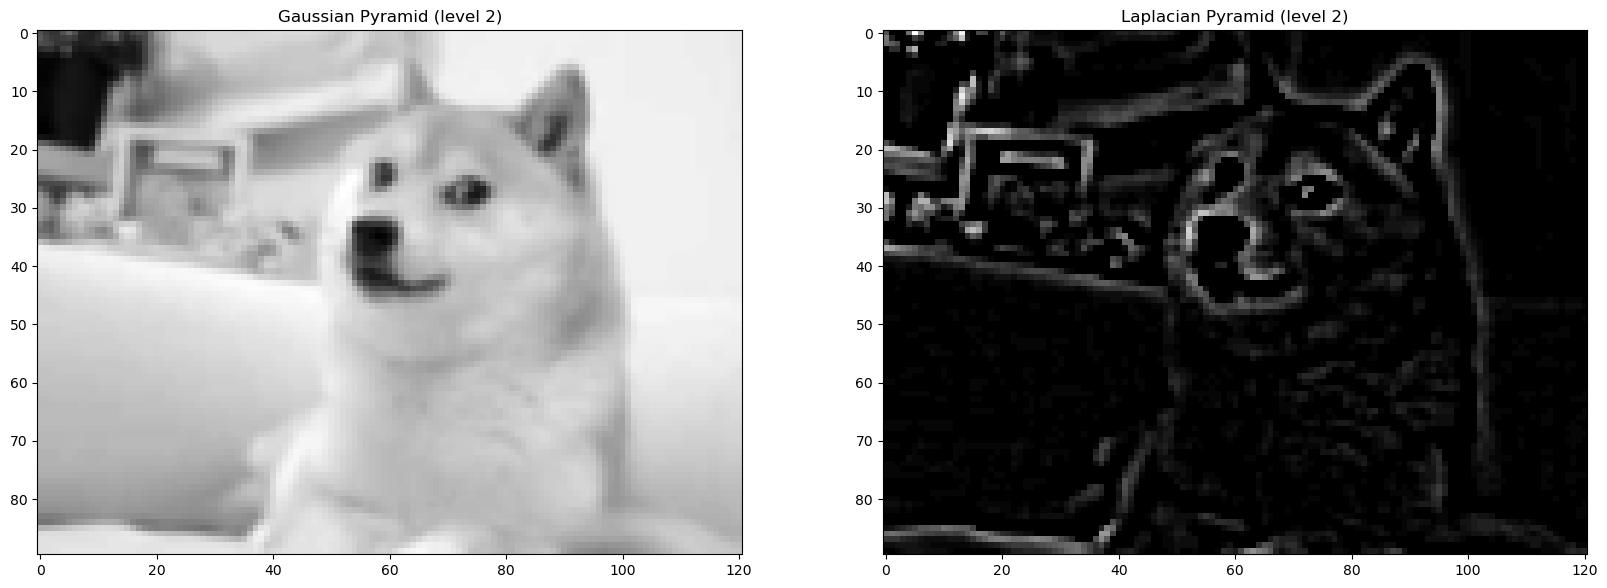

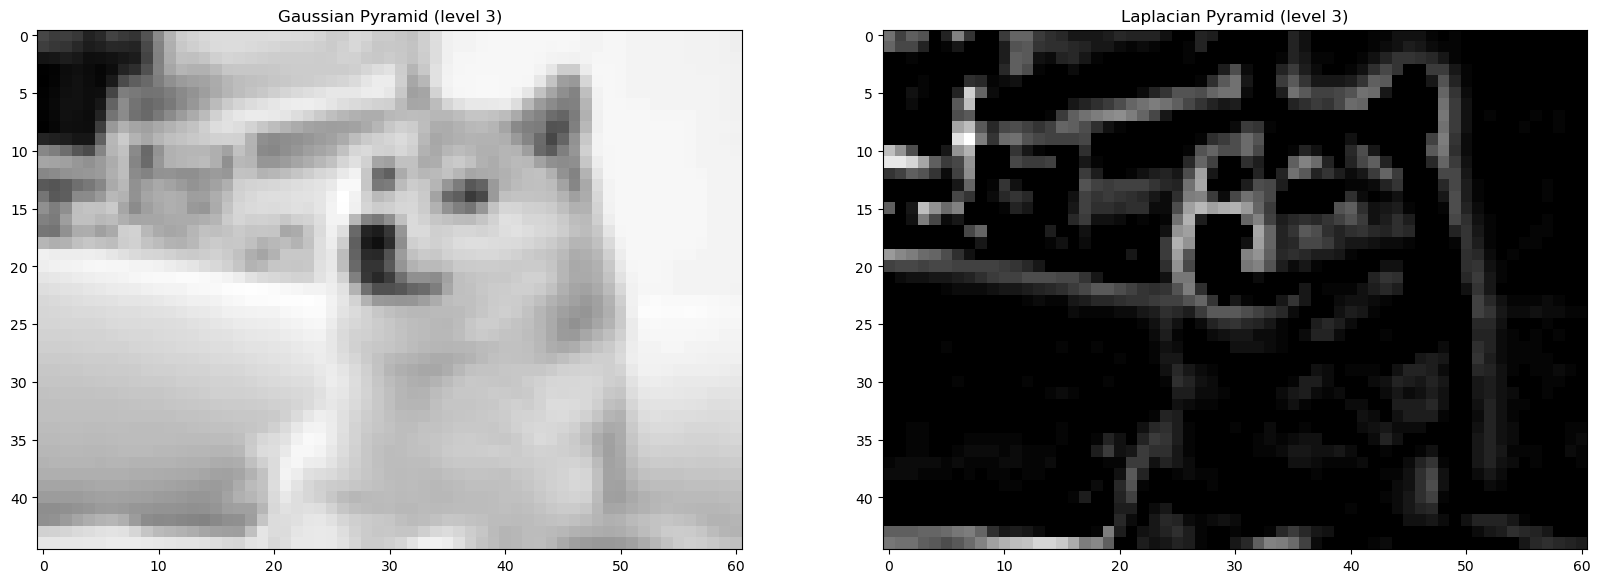

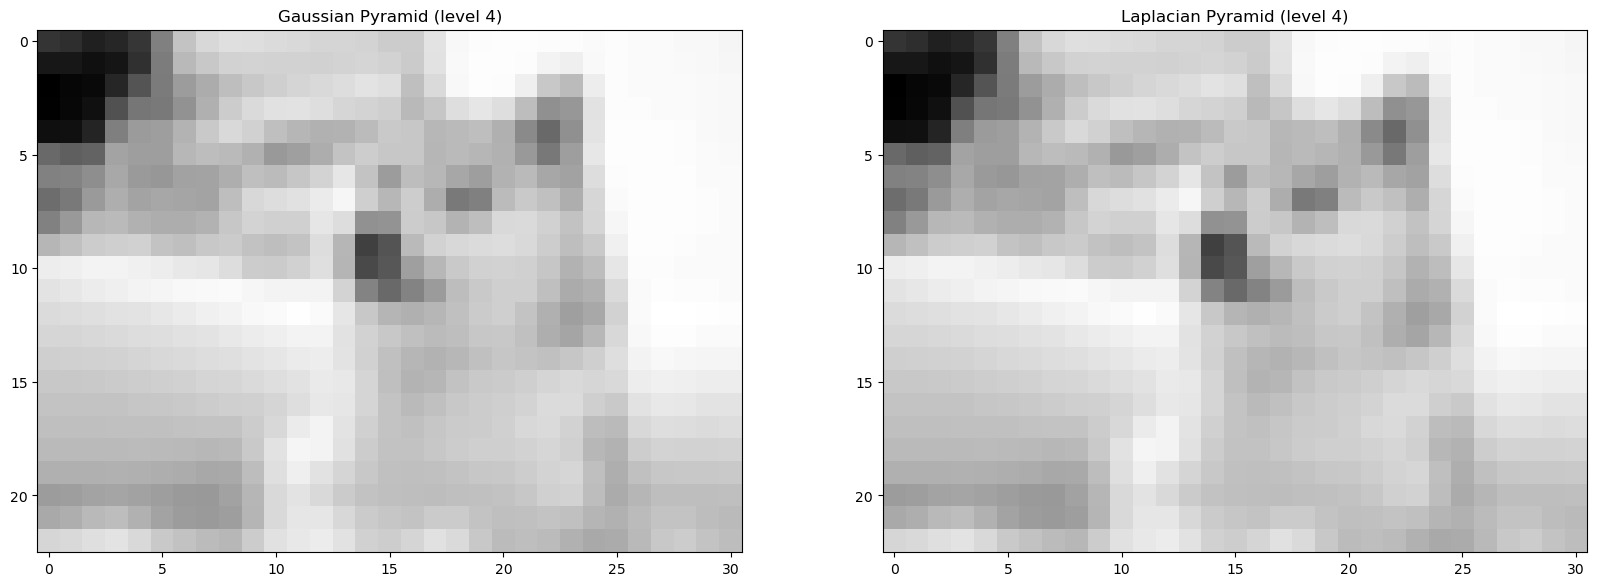

In [118]:
for i, el in enumerate(laplacian_pyramid_dog):
    display_image(f'Gaussian Pyramid (level {i})', gaussian_pyramid_dog[i], f'Laplacian Pyramid (level {i})', el)

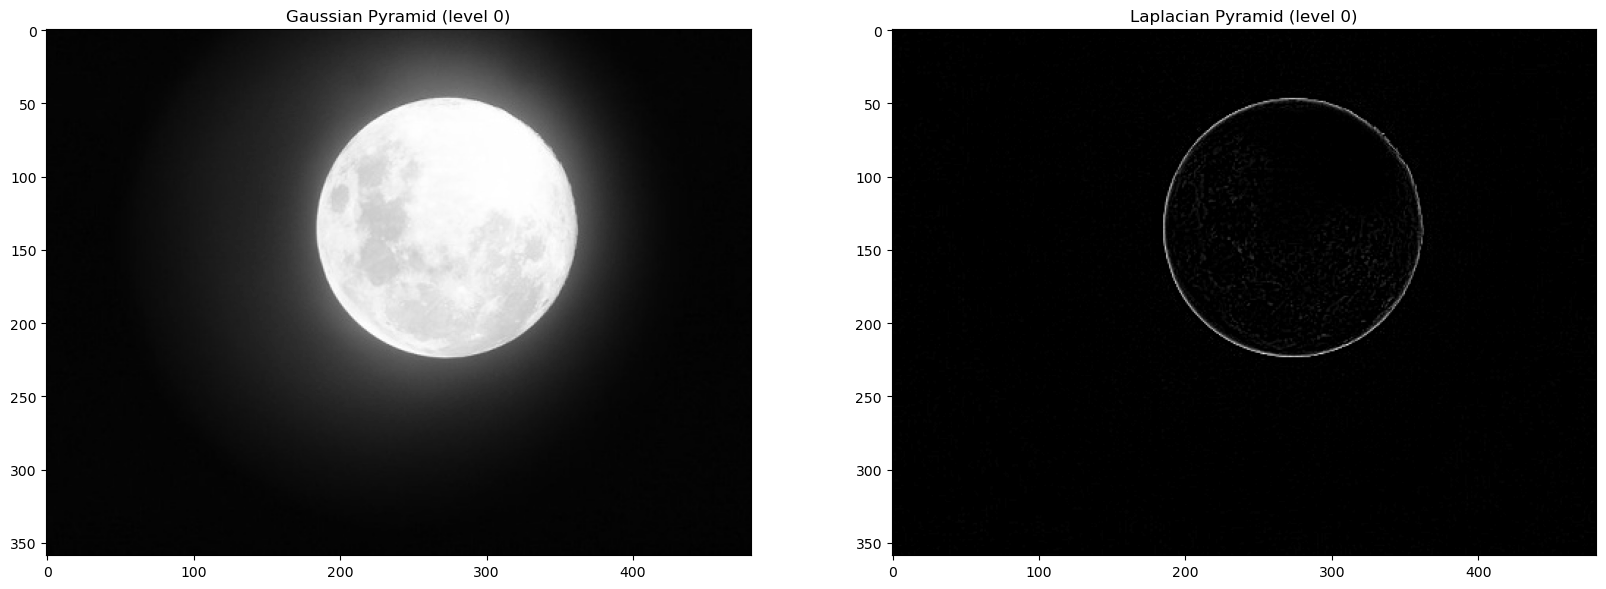

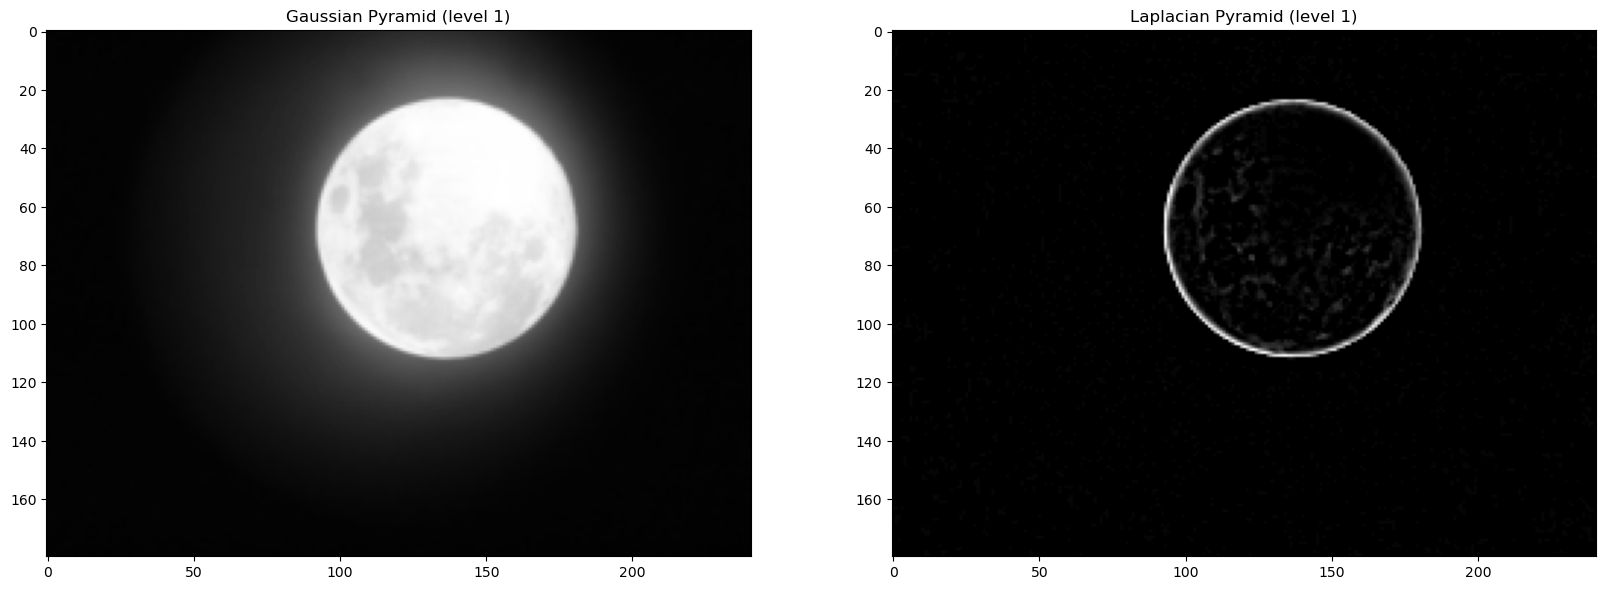

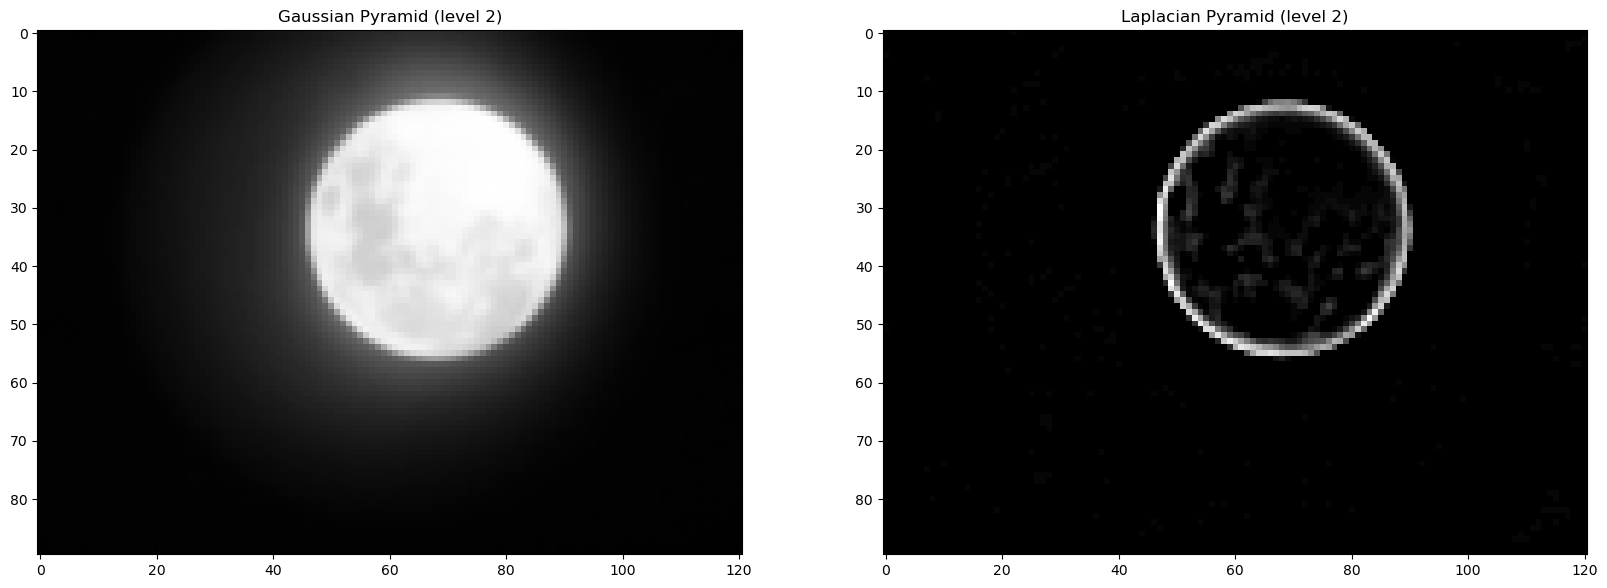

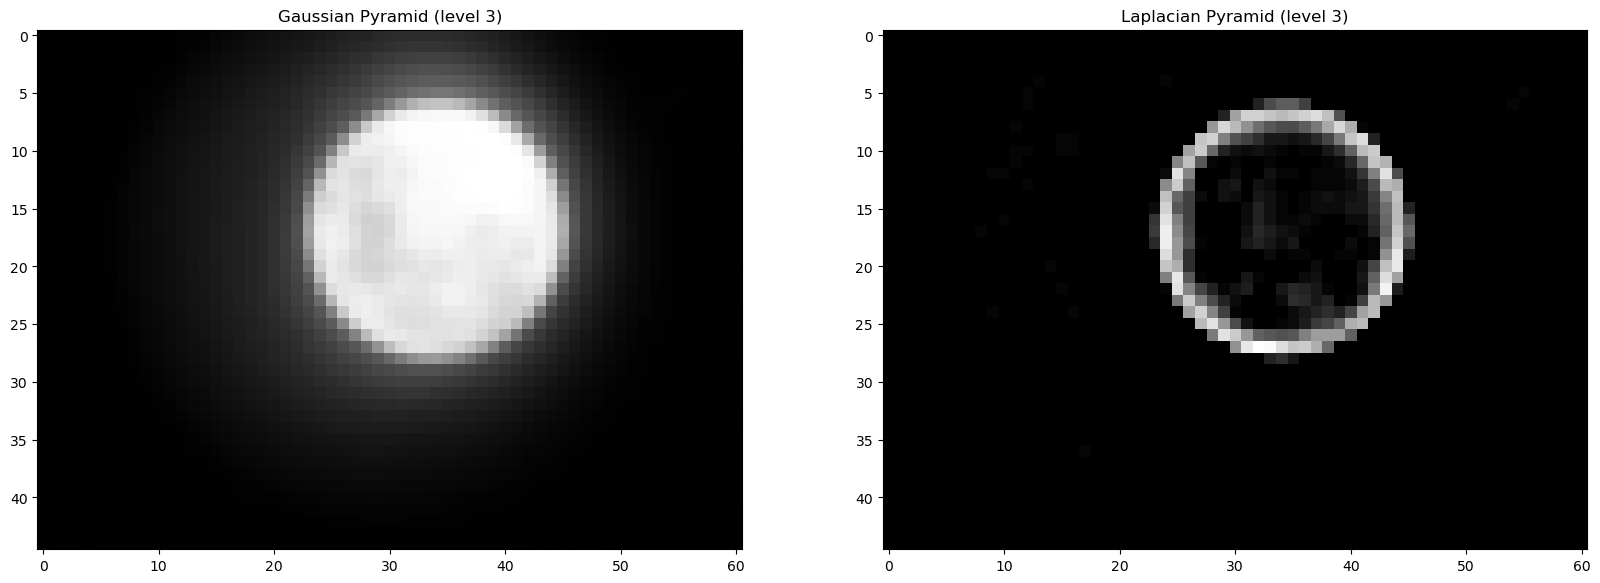

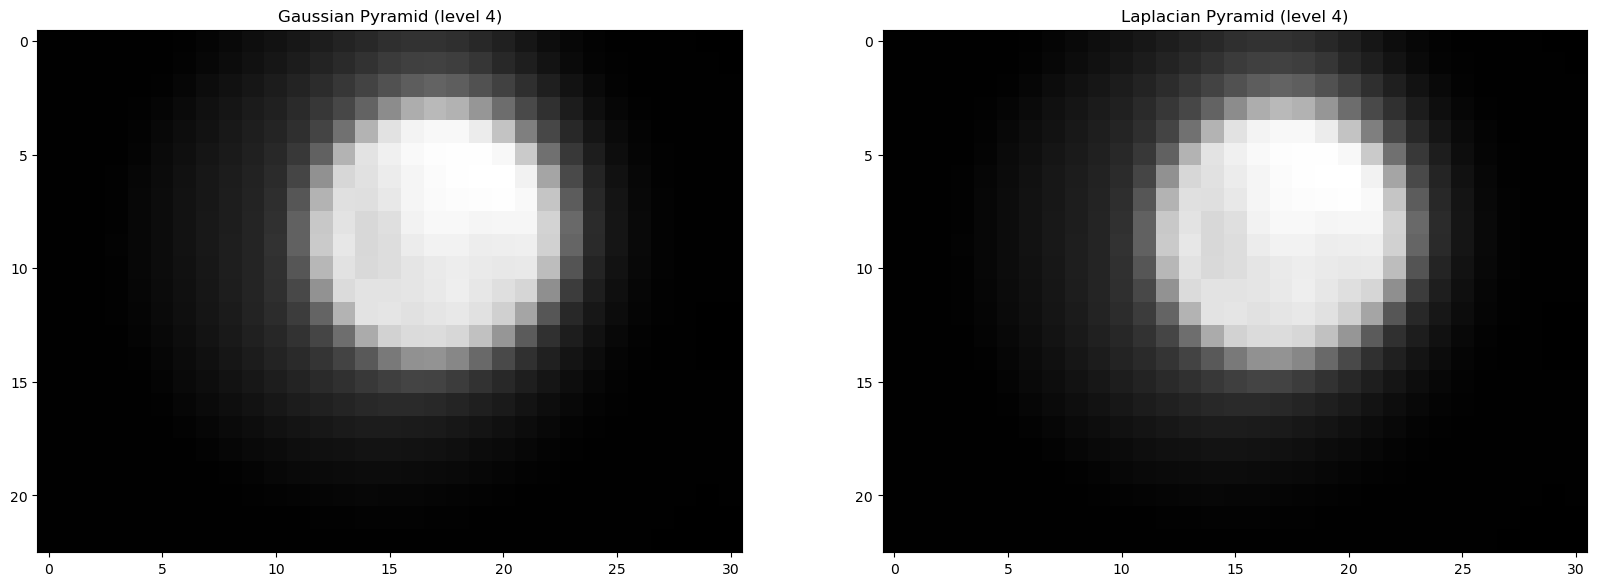

In [119]:
for i, el in enumerate(laplacian_pyramid_moon):
    display_image(f'Gaussian Pyramid (level {i})', gaussian_pyramid_moon[i], f'Laplacian Pyramid (level {i})', el)

* Blend the image dog.jpeg with the image moon.jpeg: create a Gaussian pyramid
GR for the region of interest in the given mask mask.jpeg (first transform
the mask to grayscale).

In [120]:
# set mask path
mask_path = '../data/mask.jpeg'
# read imgs
mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

# Build a Gaussian pyramid GR from selected region R
gaussian_pyramid_mask = build_gaussian_pyramid_opencv(mask, 5)



In [121]:
def blend_pyramids(laplacian_pyramid_A, laplacian_pyramid_B, gaussian_pyramid_mask):
    """
    Blends two images using laplacian pyramids and gaussian pyramid mask.
    """
    gaussian_pyramid_mask = [gaussian_pyramid_mask[i] / 255 for i in range(len(gaussian_pyramid_mask))]
    print(gaussian_pyramid_mask[0].max())
    blended_pyramid = []
    for l in range(len(laplacian_pyramid_A)):
        L_S = laplacian_pyramid_A[l] * gaussian_pyramid_mask[l] + laplacian_pyramid_B[l] * (1 - gaussian_pyramid_mask[l])
        blended_pyramid.append(L_S)
    return blended_pyramid

* Combine the Laplacian pyramids using GR as weights for the blending, i.e.
$$
LS_l(i, j) = GR_l(i, j) · LA_l(i, j) + (1 − GR_l(i, j)) · LB_l(i, j)
$$

1.0
Laplasian Pyramid of blended Dog/Moon


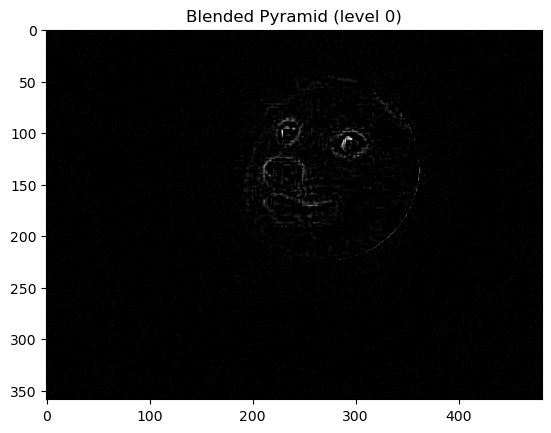

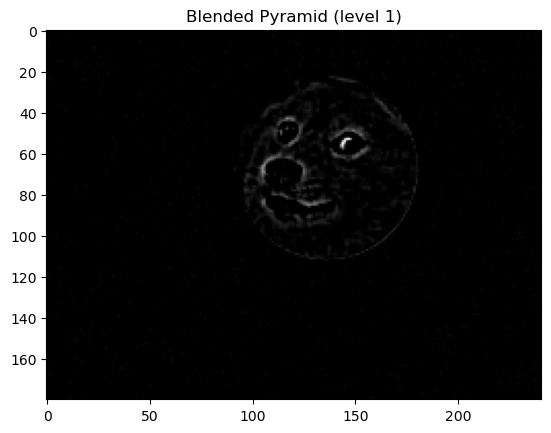

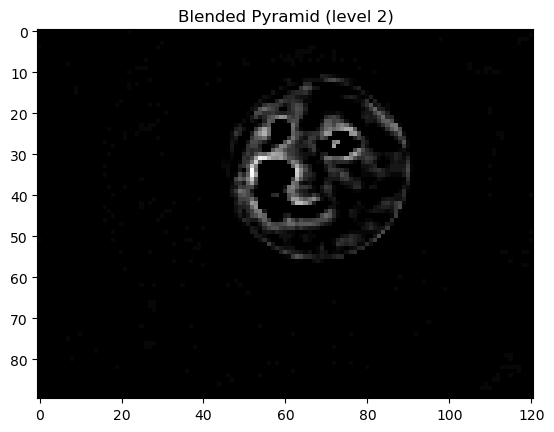

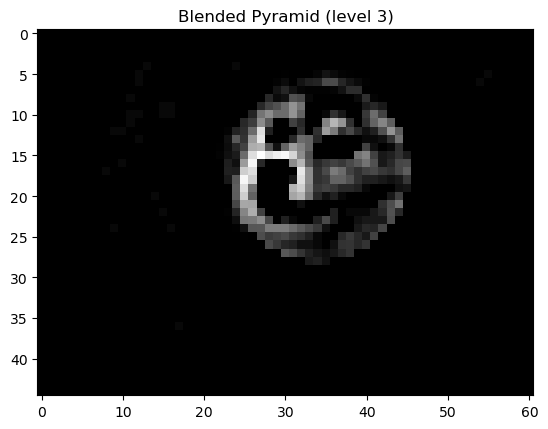

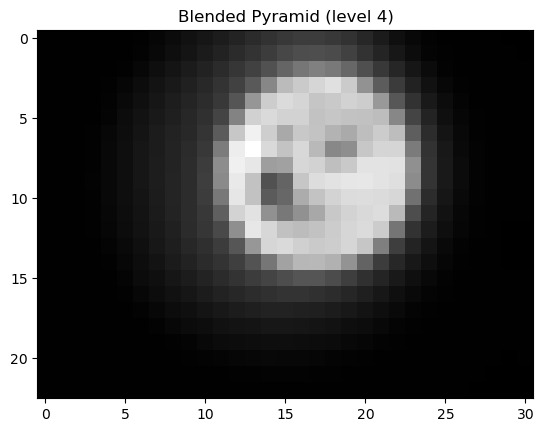

In [122]:
blended_dog_moon_pyramid = blend_pyramids(laplacian_pyramid_dog, laplacian_pyramid_moon, gaussian_pyramid_mask)

print("Laplasian Pyramid of blended Dog/Moon")
for i, el in enumerate(blended_dog_moon_pyramid):
    display_image(f'Blended Pyramid (level {i})', el)


* Collapse the LS pyramid to obtain the final composite image:
$LS_l = LS_l + expand(LS_{l+1})$. Apply the blending operation on the images
inside task4 (the results will be funny).

In [123]:
def collapse_laplacian_pyramide(blended_pyramid):
    """
    Collapses laplacian pyramid to one image.
    """
    collapsed = blended_pyramid[-1].astype(float)
    for i in range(len(blended_pyramid) - 2, -1, -1):
        # collapsed = expand_my(collapsed, blended_pyramid[i].shape)
        collapsed = cv.resize(collapsed, (blended_pyramid[i].shape[1], blended_pyramid[i].shape[0]))
        collapsed = collapsed + blended_pyramid[i]
    return ((collapsed / collapsed.max()) * 255).astype(np.uint8)

Blended Dog/Moon collapsed Image


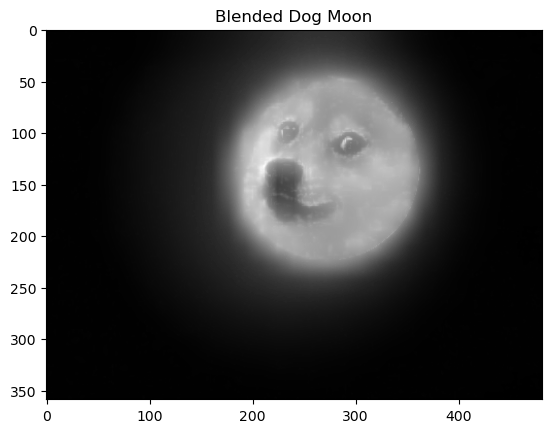

In [126]:
blended_dog_moon = collapse_laplacian_pyramide(blended_dog_moon_pyramid)
print("Blended Dog/Moon collapsed Image")
display_image('Blended Dog Moon', blended_dog_moon)

## Task 5. Edges
 In this task, we will detect edges in images using the derivative of a Gaussian
kernel. Read the image einstein.jpeg.

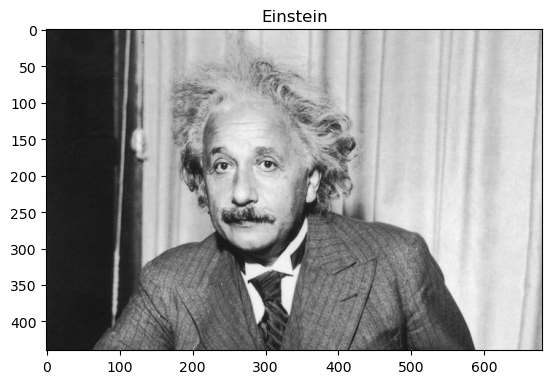

In [127]:
# set imag path
einstein_path = '../data/einstein.jpeg'
# read imgs
einstein = cv.imread(einstein_path, cv.IMREAD_GRAYSCALE)
display_image("Einstein", einstein)

* Compute the weights of the derivative (in x) of a 5x5 Gaussian kernel with
σ = 0.6.
* Compute the weights of the derivative (in y) of a 5x5 Gaussian kernel with
σ = 0.6.

In [128]:
def get_gaussian_derivative_kernel(kernel_size, sigma):
    """
    Returns a 2D Gaussian derivative kernel.
    :param kernel_size: size of the kernel
    :param sigma: sigma value of the kernel
    :return: 2D Gaussian derivative kernel
    """
    kernel_x = np.zeros((kernel_size, kernel_size))
    kernel_y = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - kernel_size // 2
            y = j - kernel_size // 2
            kernel_x[i, j] = -(x / (2 * np.pi * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma))
            kernel_y[i, j] = -(y / (2 * np.pi * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma))
      
    return kernel_x, kernel_y

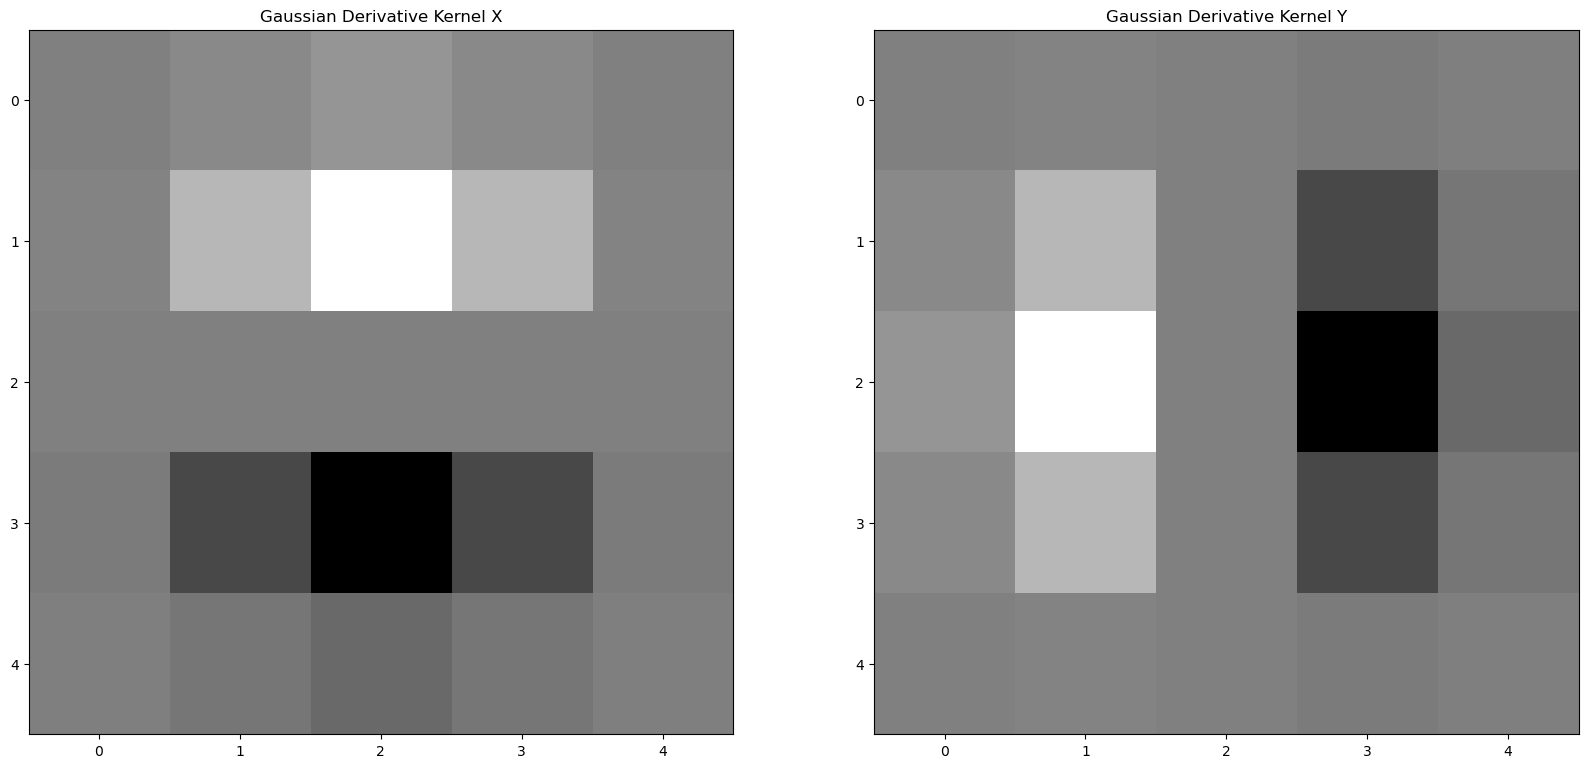

In [129]:
kernel_x, kernel_y = get_gaussian_derivative_kernel(5, 0.6)
display_image("Gaussian Derivative Kernel X", kernel_x, "Gaussian Derivative Kernel Y", kernel_y)

* To get the edges, convolve the image with the kernels computed in previous
steps. You can use cv2.filter2D.

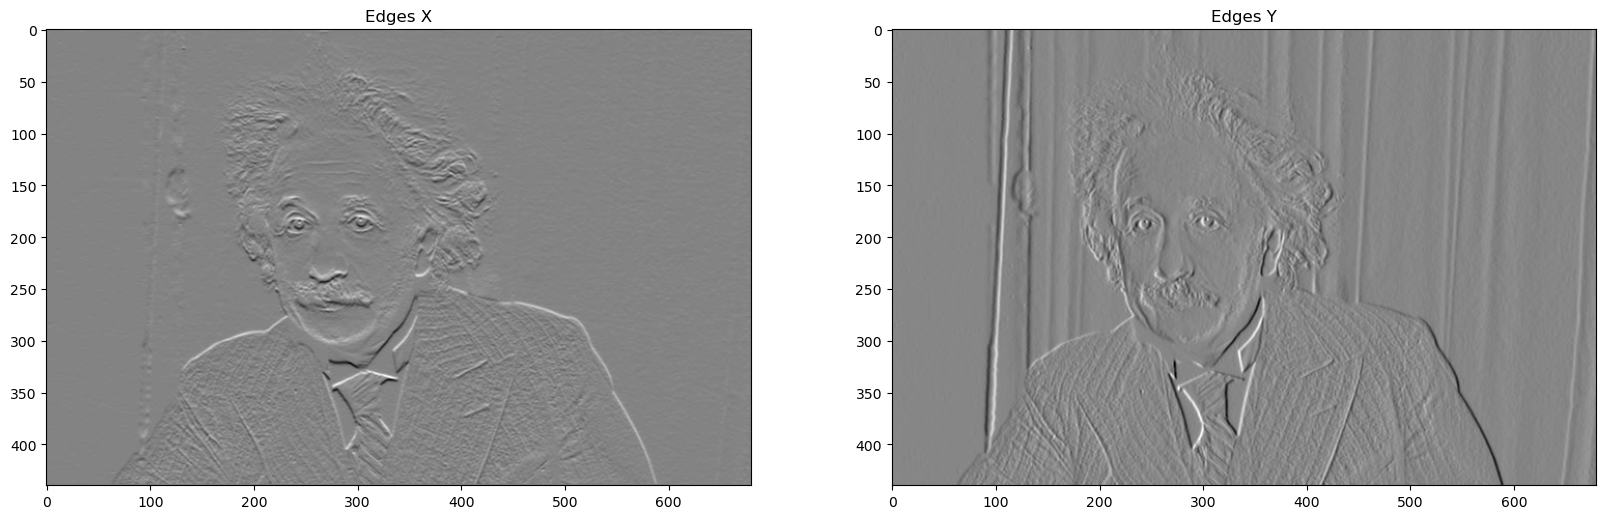

In [130]:
edges_x = cv.filter2D(einstein, ddepth=cv.CV_64F, kernel=kernel_x)
edges_y = cv.filter2D(einstein, ddepth=cv.CV_64F, kernel=kernel_y)

display_image("Edges X", edges_x, "Edges Y", edges_y)


* Compute the edge magnitude and the edge direction (you can use numpy.arctan2).
Visualise the magnitude and direction.

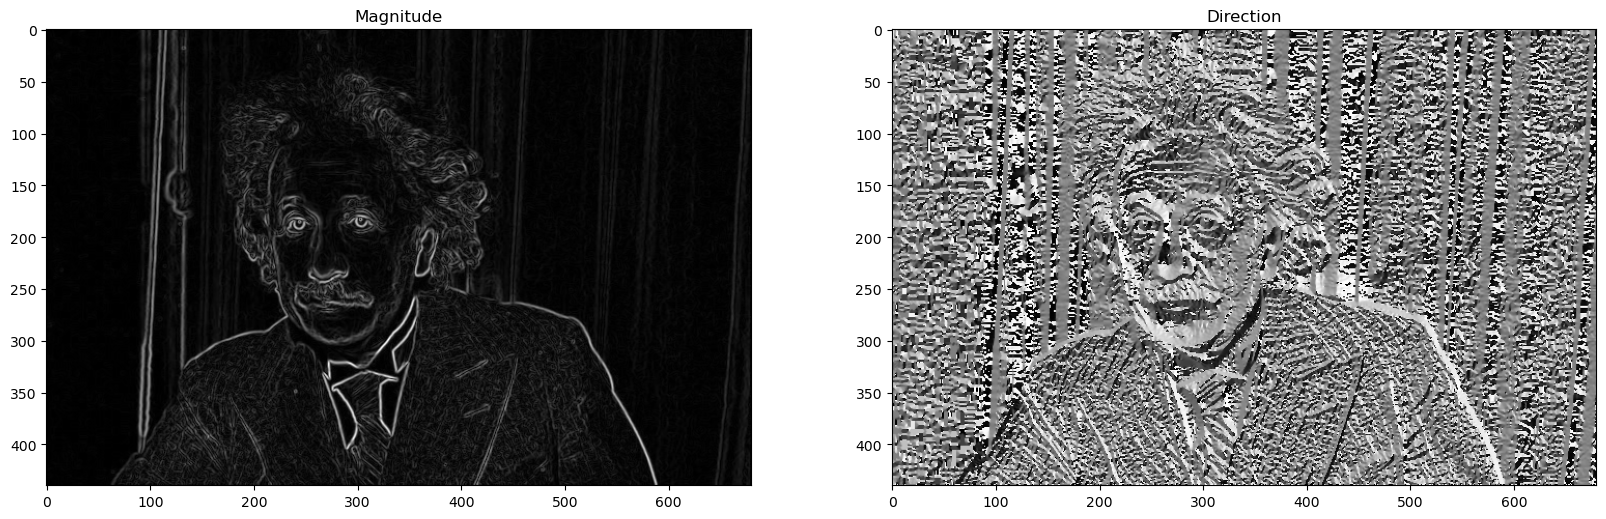

In [131]:
magnitude = np.float32(np.sqrt(edges_x ** 2 + edges_y ** 2))
direction = np.float32(np.arctan2(edges_x, edges_y))

display_image("Magnitude", magnitude, "Direction", direction)